# Extreme Weather Events and Their Impact on Temperature in Climate Projections (2006–2080)

This Python notebook serves as the analytical foundation for studying extreme weather events and their impact on temperature levels using climate projection data from 2006 to 2080. The analysis focuses on identifying heatwaves, heavy precipitation, and strong wind events, examining their frequency over time, and assessing their effects on temperature trends. 

Through descriptive statistics, data visualization, and trend analysis, this notebook explores how extreme weather events evolve over decades, and how is the impact of different variables related to changes in temperature levels.

The notebook is organised in the following sections:
1. Import Libraries
2. Load Data and Initial Exploration
3. Research Question and Extreme Weather Events
4. Time-Series Analysis and Summary Statistics
5. Drivers and Correlation Analysis
6. Conclusions
7. References & Literature

## 1. Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import matplotlib.gridspec as gridspec

## 2. Load Data and Initial Exploration

In [2]:
# Load the dataset
file_path = "project_1.csv"
df = pd.read_csv(file_path)

# Display the first few rows
df.head()

,time,TREFMXAV_U,FLNS,FSNS,PRECT,PRSN,QBOT,TREFHT,UBOT,VBOT,lat,lon
0,2006-01-02 00:00:00,282.77585,41.925180,25.926952,4.663135e-09,4.781004e-17,0.004769,279.14288,3.878579,1.394184,53.246075,357.5
1,2006-01-03 00:00:00,284.47113,8.905806,10.946910,8.046593e-08,1.295726e-16,0.006271,281.14865,1.788157,3.821703,53.246075,357.5
2,2006-01-04 00:00:00,284.28796,16.511415,6.405902,2.910936e-09,4.094447e-16,0.005782,281.22380,0.804845,-2.299140,53.246075,357.5
3,2006-01-05 00:00:00,282.12110,29.948362,9.315041,7.432505e-11,0.000000e+00,0.004277,278.39767,-1.100267,-1.258029,53.246075,357.5
4,2006-01-06 00:00:00,280.89090,19.064156,7.941241,6.894238e-12,0.000000e+00,0.003990,278.06378,-0.706321,-0.938421,53.246075,357.5


According to the documentation, this dataset contains climate or meteorological data, with variables related to temperature, wind, precipitation, and radiation fluxes.

Field Summary:

- TREFMXAV_U: Urban daily maximum of the average 2-meter air temperature (K).
- FLNS: Net longwave flux at the surface (W/m²), indicating heat radiation from the Earth’s surface.
- PRECT: Total precipitation rate (m/s), including both convective and large-scale precipitation.
- PRSN: This field is not described, but it could refer to snowfall or snow precipitation rate.
- QBOT: Water vapor mixing ratio at the lowest model level (kg/kg), indicating humidity near the surface.
- TREFHT: Reference height temperature (K), likely near-surface temperature.
- UBOT: Zonal wind component at the lowest model level (m/s), representing wind speed in the east-west direction.
- VBOT: Meridional wind component at the lowest model level (m/s), representing wind speed in the north-south direction.

### High-level Exploration

In [3]:
df.describe()

,TREFMXAV_U,FLNS,FSNS,PRECT,PRSN,QBOT,TREFHT,UBOT,VBOT,lat,lon
count,27374.000000,27374.000000,27374.000000,2.737400e+04,2.737400e+04,27374.000000,27374.000000,27374.000000,27374.000000,2.737400e+04,27374.0
mean,288.836179,42.995679,97.026261,3.379697e-08,3.049825e-10,0.006523,284.876413,1.176320,1.503084,5.324608e+01,357.5
std,5.246468,21.451927,75.062880,4.986518e-08,4.706017e-09,0.002126,4.992277,3.066843,2.940138,7.105557e-15,0.0
min,274.153200,0.611385,2.819259,-4.671764e-28,-6.256338e-21,0.001855,268.938400,-9.739025,-8.991429,5.324607e+01,357.5
25%,284.719465,26.157544,31.037187,2.131118e-09,0.000000e+00,0.004860,280.987885,-1.085982,-0.766405,5.324607e+01,357.5
50%,288.299895,40.777005,78.443183,1.311730e-08,1.206375e-21,0.006211,284.537575,1.488009,1.593354,5.324607e+01,357.5
75%,292.869525,57.113572,149.332133,4.637272e-08,2.348279e-16,0.007947,288.900110,3.390555,3.634500,5.324607e+01,357.5
max,311.257260,111.851400,310.191700,7.752961e-07,2.332090e-07,0.015222,303.117980,10.234506,11.178102,5.324607e+01,357.5


Based on the latitude and longitude attributes (53.246075, 357.5), we identified a unique location within the dataset. The longitude of 357.5 degrees is equivalent to -2.5 degrees (calculated as 357.5 - 360). This coordinate pair corresponds to a location in Norwich, UK.

https://maps.app.goo.gl/5SSJsN9UawWNFhLq6

In [4]:
print("Unique latitudes:", df['lat'].unique())
print("Unique longitudes:", df['lon'].unique())

Unique latitudes: [53.246075]
Unique longitudes: [357.5]


### Problem and Research Question

Extreme weather events, encompassing heavy precipitation, snowfall, and extreme heat, pose significant challenges globally, impacting infrastructure, agriculture, public safety, and energy demand. The UK, in particular, faces substantial risks from these events, with studies highlighting their detrimental effects on public health, mental well-being (Cruz et al., 2020), and widespread flooding (Darwish et al., 2020). While recent climate modeling advancements, such as those using UKCP18 projections (Lo et al., 2020), have shed light on urban heat island trends and the atmospheric drivers of extreme precipitation, distinguishing between winter atmospheric river-driven events and summer convective events (Allan et al., 2016), a comprehensive understanding of how the full spectrum of extreme weather (heatwaves, heavy precipitation, strong winds) is projected to evolve over the coming decades remains incomplete. Therefore a gap persists and lead to the need for this research question:

**How do extreme weather events (heatwaves, heavy precipitation, strong winds) evolve over time in climate projections from 2006 to 2080, and how do they impact temperature levels in different future periods?**

### Data Preprocessing

To conduct the analysis we first run several data preprocessing steps:

1. Convert the 'time' column to datetime format.
2. Extract the year and month from the 'time' column and create new columns 'year' and 'month'.
3. Compute the wind speed magnitude (UVBOT) using the l2norm on the zonal (UBOT) and meridional (VBOT) wind components.
4. Convert temperature columns from Kelvin to Celsius.

In [5]:
# Convert the 'time' column to datetime format
df['time'] = pd.to_datetime(df['time'])

# Extract month and year from the 'time' column
df['year'] = df['time'].dt.year
df['month'] = df['time'].dt.month

# Compute wind speed magnitude
df["UVBOT"] = np.sqrt(df["UBOT"]**2 + df["VBOT"]**2)

# Transform temperature columns to Celsius
df["TREFMXAV_U_C"] = df["TREFMXAV_U"] - 273.15
df["TREFHT_C"] = df["TREFHT"] - 273.15

## 3. Extreme Weather Events Definition

Based on the literature, we have defined a base period for the analysis: 2006 to 2016, which serves as a reference for analysing extreme events in each decade. 

Extreme events are identified based on values that exceed certain percentiles within this base period. For this exercise, we define them as follows: 

- **HT95 (Warm Days):** Days (per year/season/month) with temperatures exceeding a site-specific threshold, calculated as the calendar-day 95th percentile of the daily temperature distribution in the baseline period. 
 
- **LT05 (Cold Days):** Days (per year/season/month) with temperatures below a site-specific threshold, calculated as the calendar-day 5th percentile of the daily temperature distribution in the baseline period. 

- **R95 (Precipitation Extremes):** Days (per year/season/month) with precipitation amounts exceeding a site-specific threshold for moderate and very wet days, calculated as the 95th percentile of the daily precipitation distribution in the baseline period. 

- **W95 (Wind Extremes):** Days (per year/season/month) with wind speeds exceeding a site-specific threshold for moderate and very windy days, calculated as the 95th percentile of the daily wind speed distribution in the baseline period. 

In [6]:
# Create a reference period from 2006 to 2016
reference_period = df[(df["year"] >= 2006) & (df["year"] <= 2016)]

# Thresholds definition
HT95 = 0.95 # High temperature days 
LT05 = 0.05 # Low temperature days
R95 = 0.95 # Very wet days
W95 = 0.95 # Very windy days

# Define 95th percentile thresholds for extreme events based on the reference period
indices = {
    "heatwave": reference_period["TREFMXAV_U"].quantile(HT95),
    "cold_days": reference_period["TREFHT"].quantile(LT05),
    "heavy_precipitation": reference_period["PRECT"].quantile(R95),
    "strong_winds": reference_period["UVBOT"].quantile(W95)
}

# Create boolean columns for extreme events
df["heatwave"] = df["TREFMXAV_U"] > indices["heatwave"]
df["cold_days"] = df["TREFHT"] < indices["cold_days"]
df["heavy_precipitation"] = df["PRECT"] > indices["heavy_precipitation"]
df["strong_winds"] = df["UVBOT"] > indices["strong_winds"]

# Create a column to store the label of the extreme weather event
df["extreme_event_label"] = np.nan
df.loc[df["heatwave"], "extreme_event_label"] = "heatwave"
df.loc[df["cold_days"], "extreme_event_label"] = "cold_days"
df.loc[df["heavy_precipitation"], "extreme_event_label"] = "heavy_precipitation"
df.loc[df["strong_winds"], "extreme_event_label"] = "strong_winds"

# Count occurrences of extreme events
event_counts = df[["heatwave", "cold_days", "heavy_precipitation", "strong_winds"]].sum()

# Convert event counts to a DataFrame for better display
event_counts_df = event_counts.to_frame(name="Extreme Event Count")
event_counts_df

,Extreme Event Count
heatwave,3621
cold_days,991
heavy_precipitation,1464
strong_winds,1469


## 4. Time-Series Analysis and Summary Statistics

 Step 3: Summarize Frequency, Duration, and Seasonal Trends. This code includes:
Computing summary statistics (mean, min, max, standard deviation)
Visualizing event distributions (histograms and boxplots)
Analyzing seasonal trends (time-series plots)

Summary Statistics of Extreme Weather Events:
       heatwave cold_days heavy_precipitation strong_winds
count     27374     27374               27374        27374
unique        2         2                   2            2
top       False     False               False        False
freq      23753     26383               25910        25905


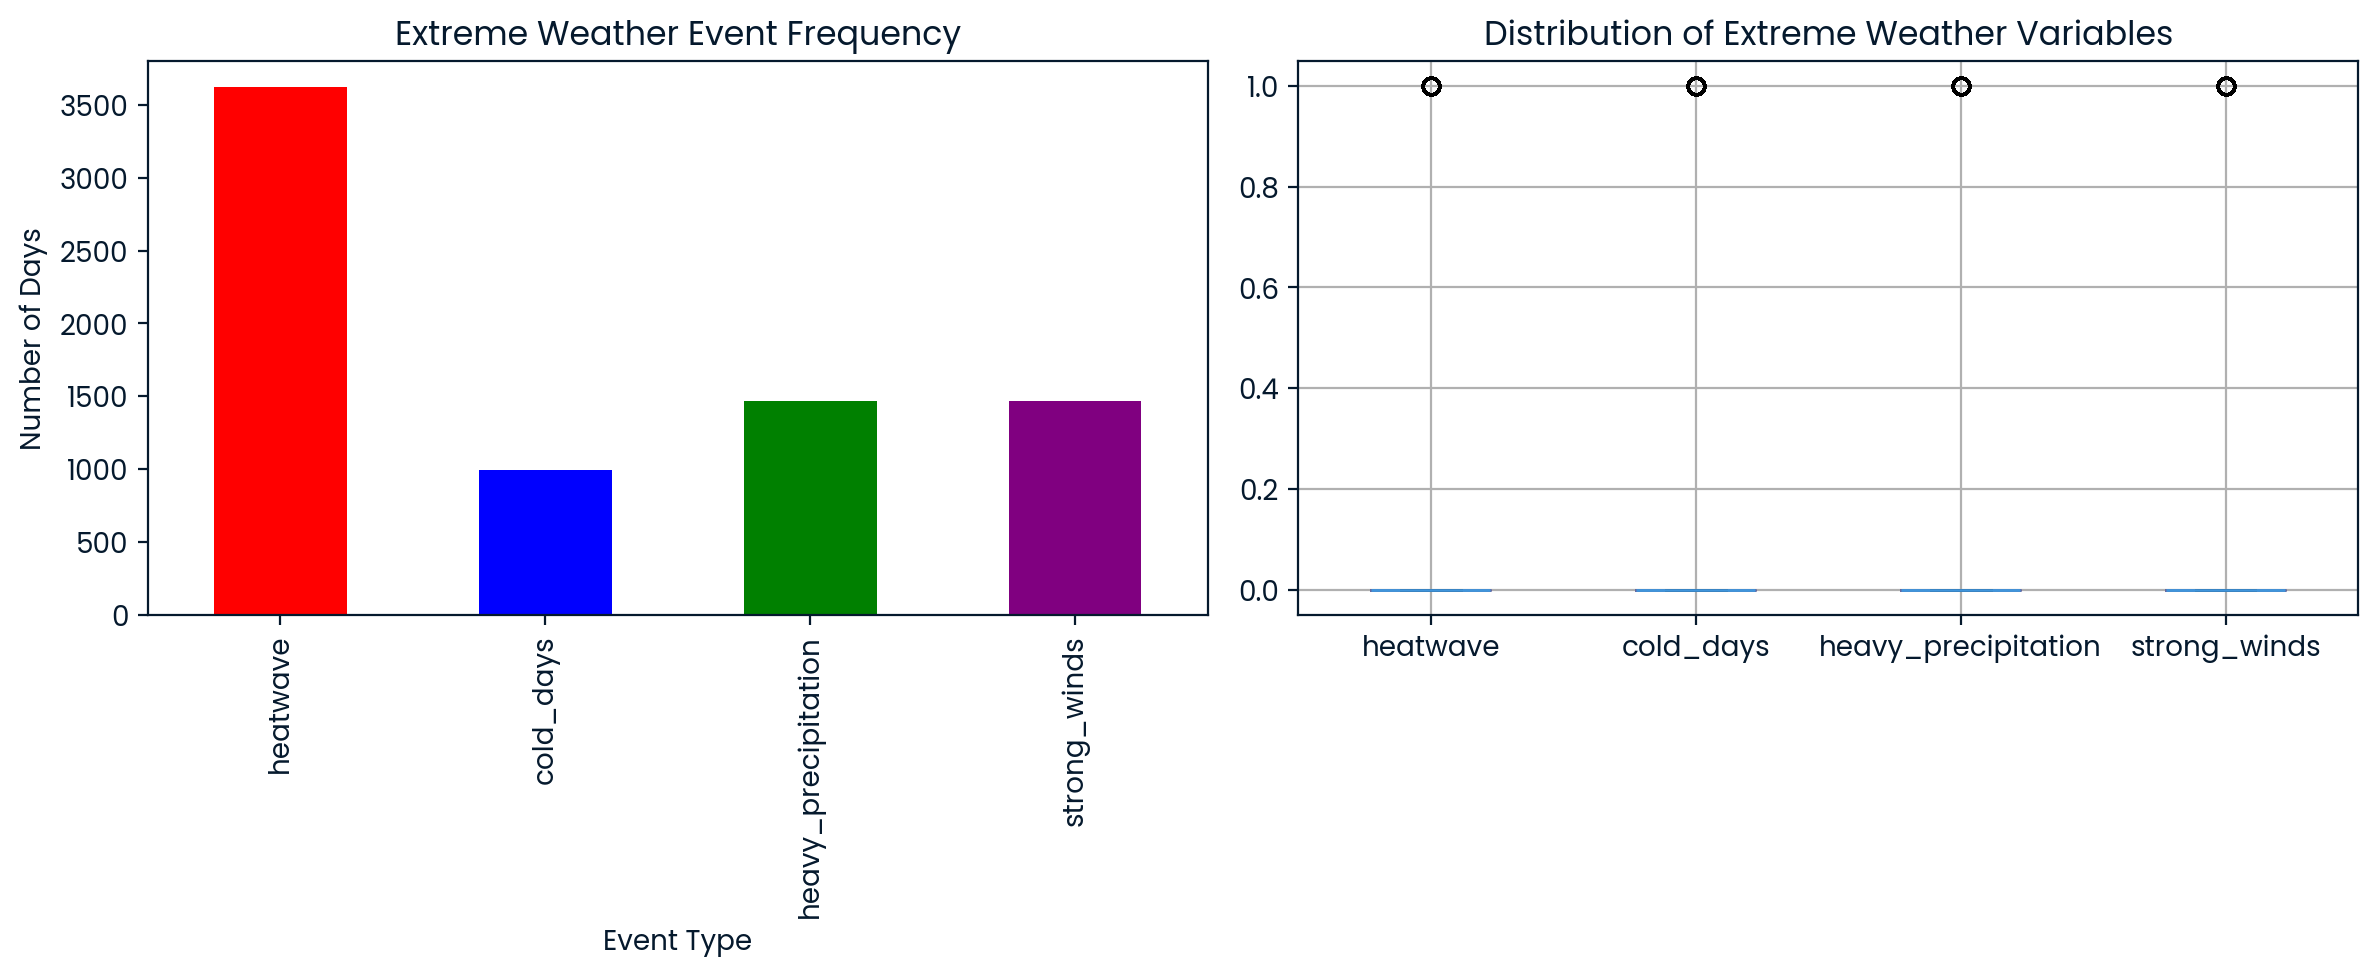

In [7]:
# Step 3: Compute summary statistics
summary_stats = df[["heatwave","cold_days", "heavy_precipitation", "strong_winds"]].describe()

# Print summary statistics
print("Summary Statistics of Extreme Weather Events:")
print(summary_stats)

# Visualizing event distributions using histograms and boxplots
plt.figure(figsize=(12, 5))

# Histogram of extreme weather events
plt.subplot(1, 2, 1)
df[["heatwave","cold_days", "heavy_precipitation", "strong_winds"]].sum().plot(kind="bar", color=['red', 'blue', 'green','purple'])
plt.title("Extreme Weather Event Frequency")
plt.ylabel("Number of Days")
plt.xlabel("Event Type")

# Boxplots for visualizing data distribution
plt.subplot(1, 2, 2)
df[["heatwave","cold_days", "heavy_precipitation", "strong_winds"]].boxplot()
plt.title("Distribution of Extreme Weather Variables")

plt.tight_layout()
plt.show()

Step 4: Analyze Seasonal Trends

Seasonal Trends of Extreme Weather Events:
       heatwave  heavy_precipitation  strong_winds
month                                             
1             0                  154           357
2             0                  106           282
3             3                   80           173
4            70                   61            65
5           262                   72            19
6           798                  105             1
7          1210                   95             0
8           976                  114             2
9           279                  119            25
10           23                  159            64
11            0                  183           185
12            0                  216           296


<Figure size 1000x600 with 0 Axes>

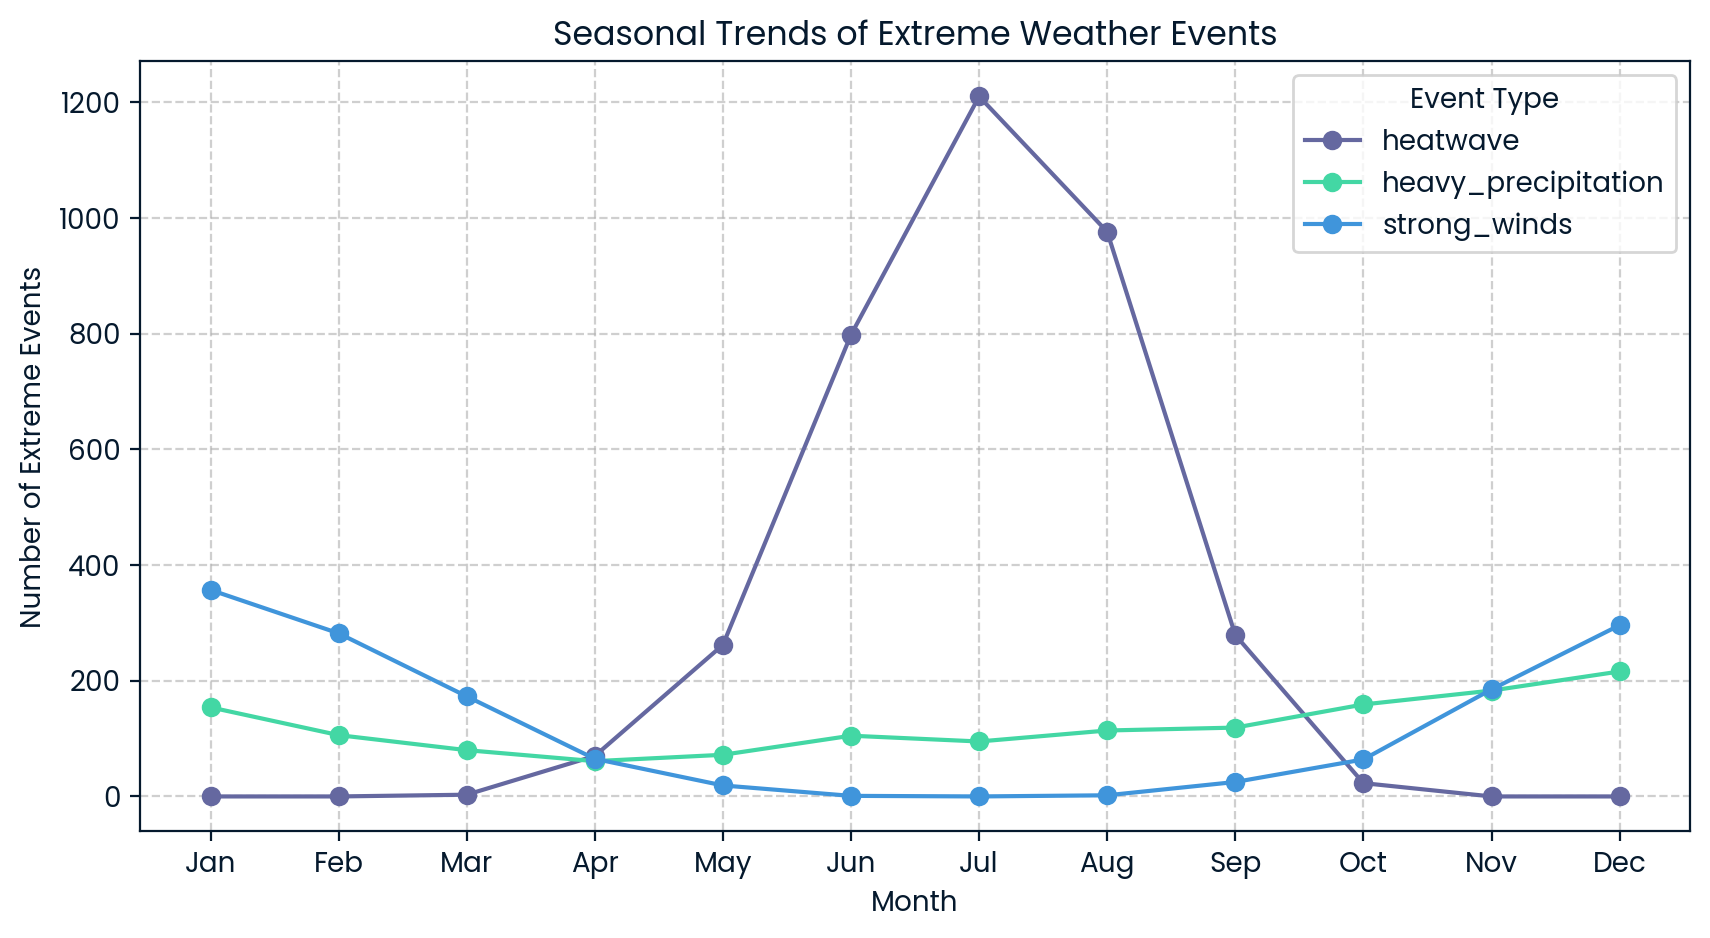

In [8]:
# Group extreme weather events by month
seasonal_trends = df.groupby("month")[["heatwave", "heavy_precipitation", "strong_winds"]].sum()

# Display seasonal trends data
print("Seasonal Trends of Extreme Weather Events:")
print(seasonal_trends)

# Plot seasonal trends using a time-series line graph
plt.figure(figsize=(10, 6))
seasonal_trends.plot(kind="line", marker="o", linestyle="-", figsize=(10, 5))
plt.xlabel("Month")
plt.ylabel("Number of Extreme Events")
plt.title("Seasonal Trends of Extreme Weather Events")
plt.xticks(ticks=range(1, 13), labels=[
    "Jan", "Feb", "Mar", "Apr", "May", "Jun",
    "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"
])  # Label months
plt.legend(title="Event Type")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

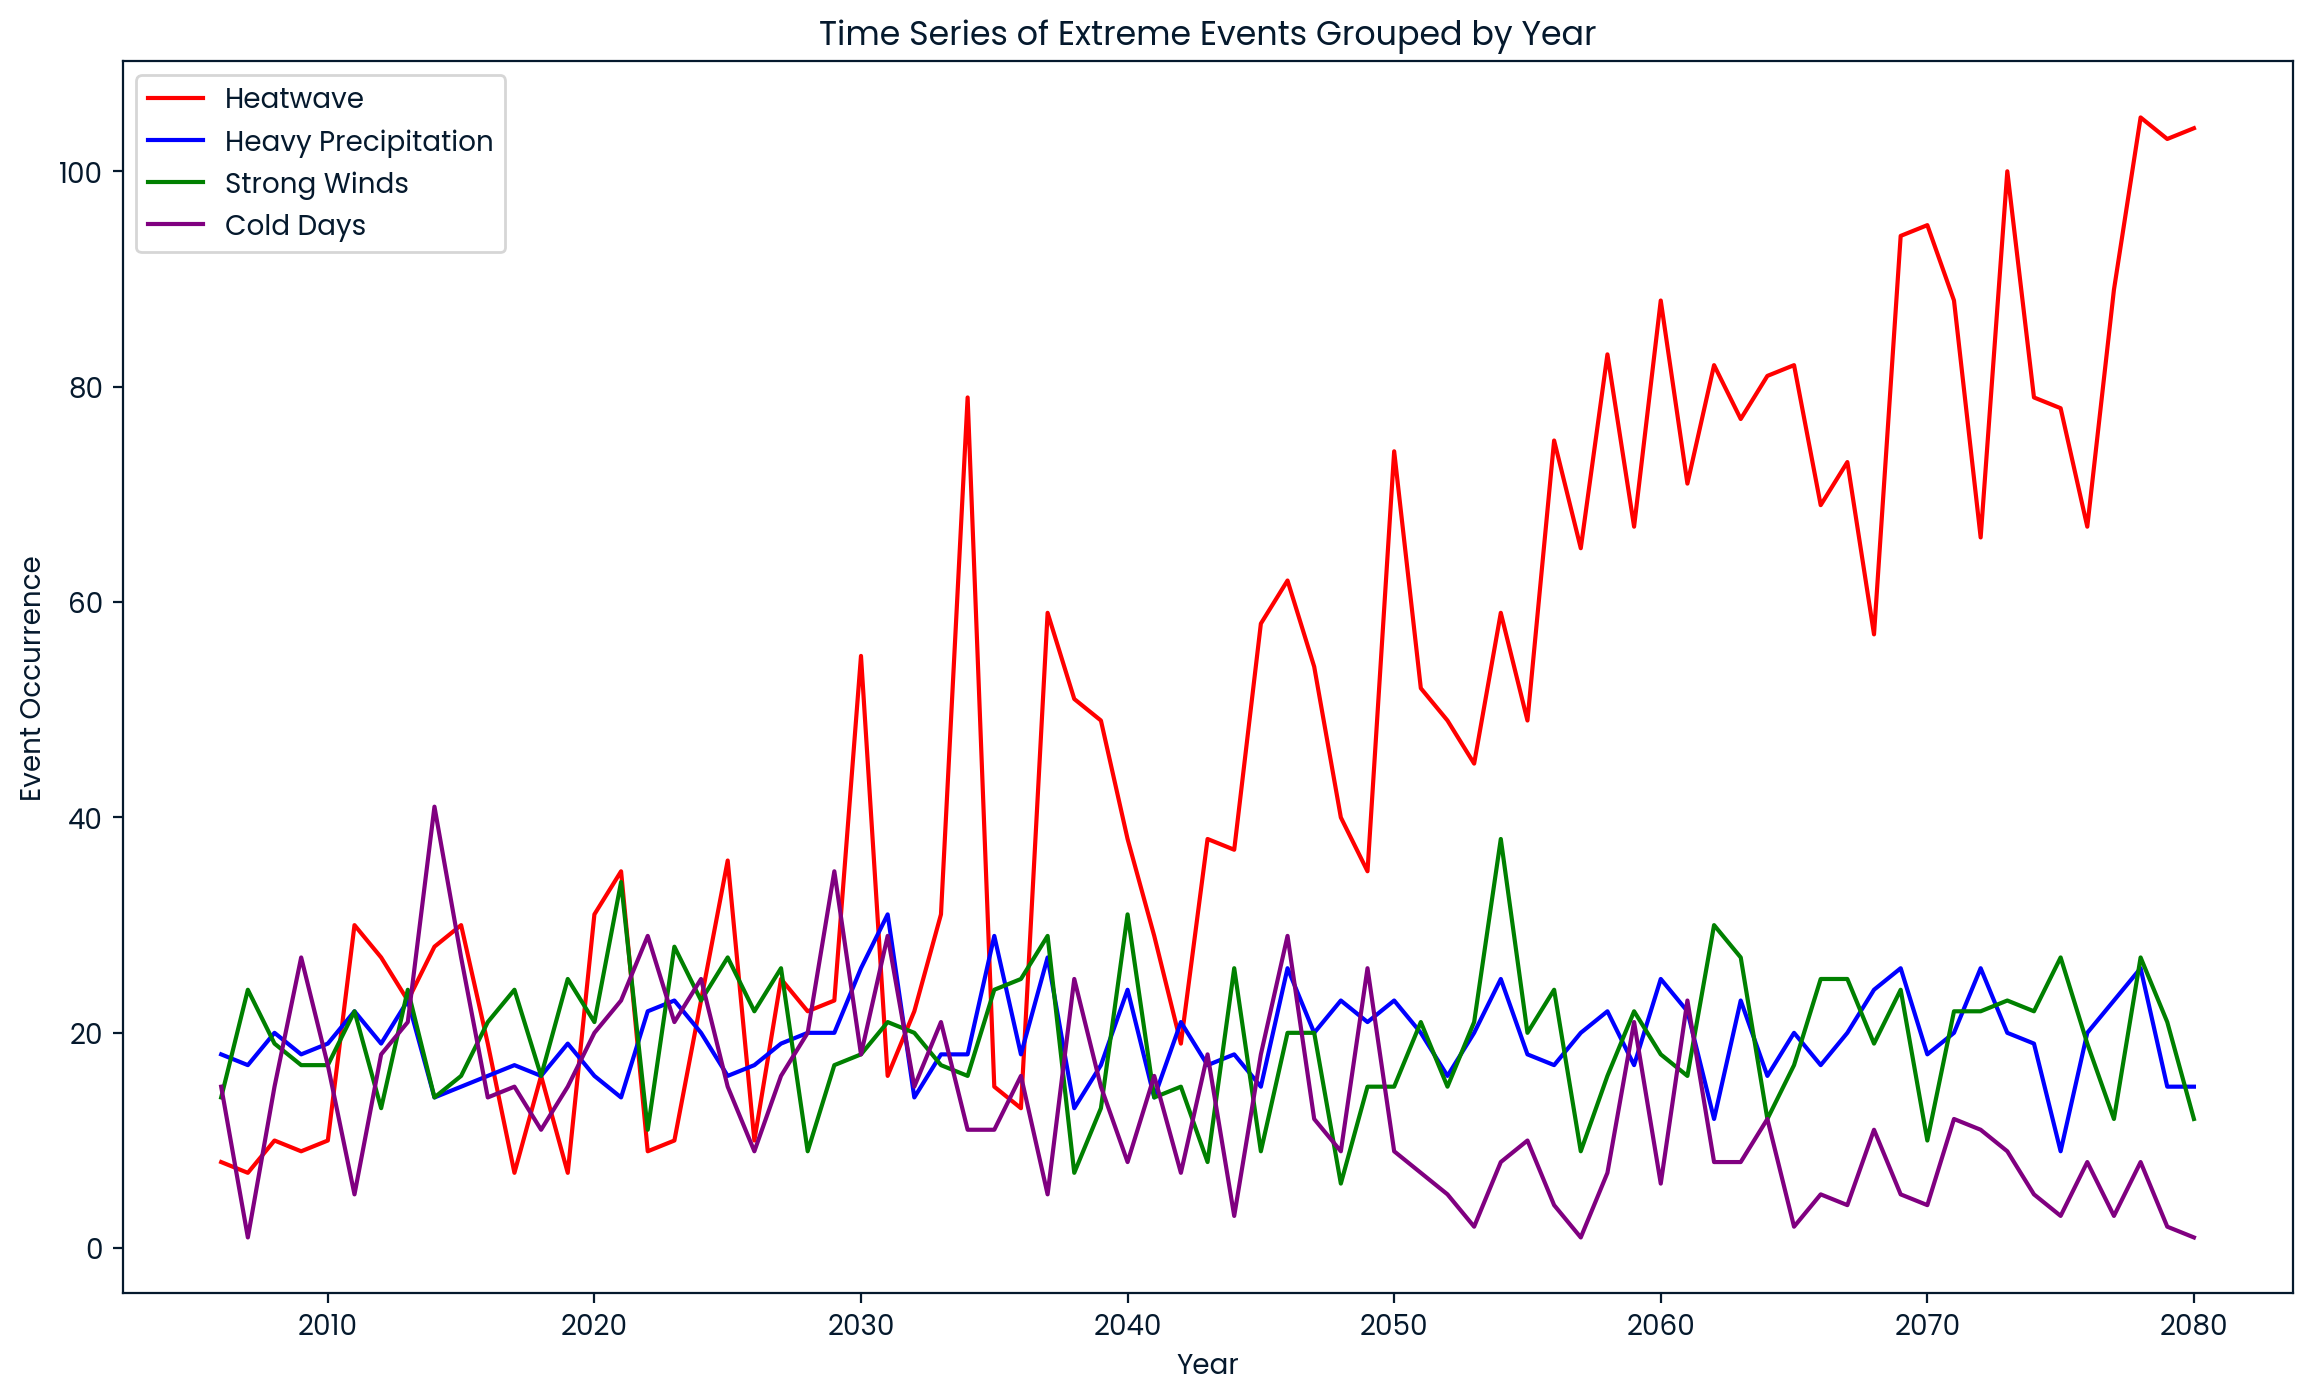

In [9]:
# Grouping by year
grouped_df = df.groupby('year')[['heatwave', 'heavy_precipitation', 'strong_winds', 'cold_days']].sum().reset_index()

# Plotting the time series for heatwave, heavy precipitation, strong winds, and cold days using grouped_df
plt.figure(figsize=(14, 8))

# Plot heatwave
plt.plot(grouped_df['year'], grouped_df['heatwave'], label='Heatwave', color='red')

# Plot heavy precipitation
plt.plot(grouped_df['year'], grouped_df['heavy_precipitation'], label='Heavy Precipitation', color='blue')

# Plot strong winds
plt.plot(grouped_df['year'], grouped_df['strong_winds'], label='Strong Winds', color='green')

# Plot cold days
plt.plot(grouped_df['year'], grouped_df['cold_days'], label='Cold Days', color='purple')

# Adding title and labels
plt.title('Time Series of Extreme Events Grouped by Year')
plt.xlabel('Year')
plt.ylabel('Event Occurrence')
plt.legend()

# Display the plot
plt.show()

In [10]:
# Grouping by decade
df['decade'] = (df['year'] // 10) * 10
grouped_df_decade = df.groupby('decade')[['heatwave',
       'heavy_precipitation', 'strong_winds']].sum().reset_index()

# Remove 2000 and 2080 decades
grouped_df_decade = grouped_df_decade[~grouped_df_decade['decade'].isin([2000, 2080])]

# Compute the number of yearly average extreme weather events per decade
grouped_df_decade['avg_heatwave_per_year'] = grouped_df_decade['heatwave'] / 10
grouped_df_decade['avg_heavy_precipitation_per_year'] = grouped_df_decade['heavy_precipitation'] / 10
grouped_df_decade['avg_strong_winds_per_year'] = grouped_df_decade['strong_winds'] / 10

# Display the updated dataframe
grouped_df_decade

,decade,heatwave,heavy_precipitation,strong_winds,avg_heatwave_per_year,avg_heavy_precipitation_per_year,avg_strong_winds_per_year
1,2010,197,180,192,19.7,18.0,19.2
2,2020,224,187,218,22.4,18.7,21.8
3,2030,390,211,190,39.0,21.1,19.0
4,2040,410,199,164,41.0,19.9,16.4
5,2050,618,198,201,61.8,19.8,20.1
6,2060,774,205,213,77.4,20.5,21.3
7,2070,870,196,205,87.0,19.6,20.5


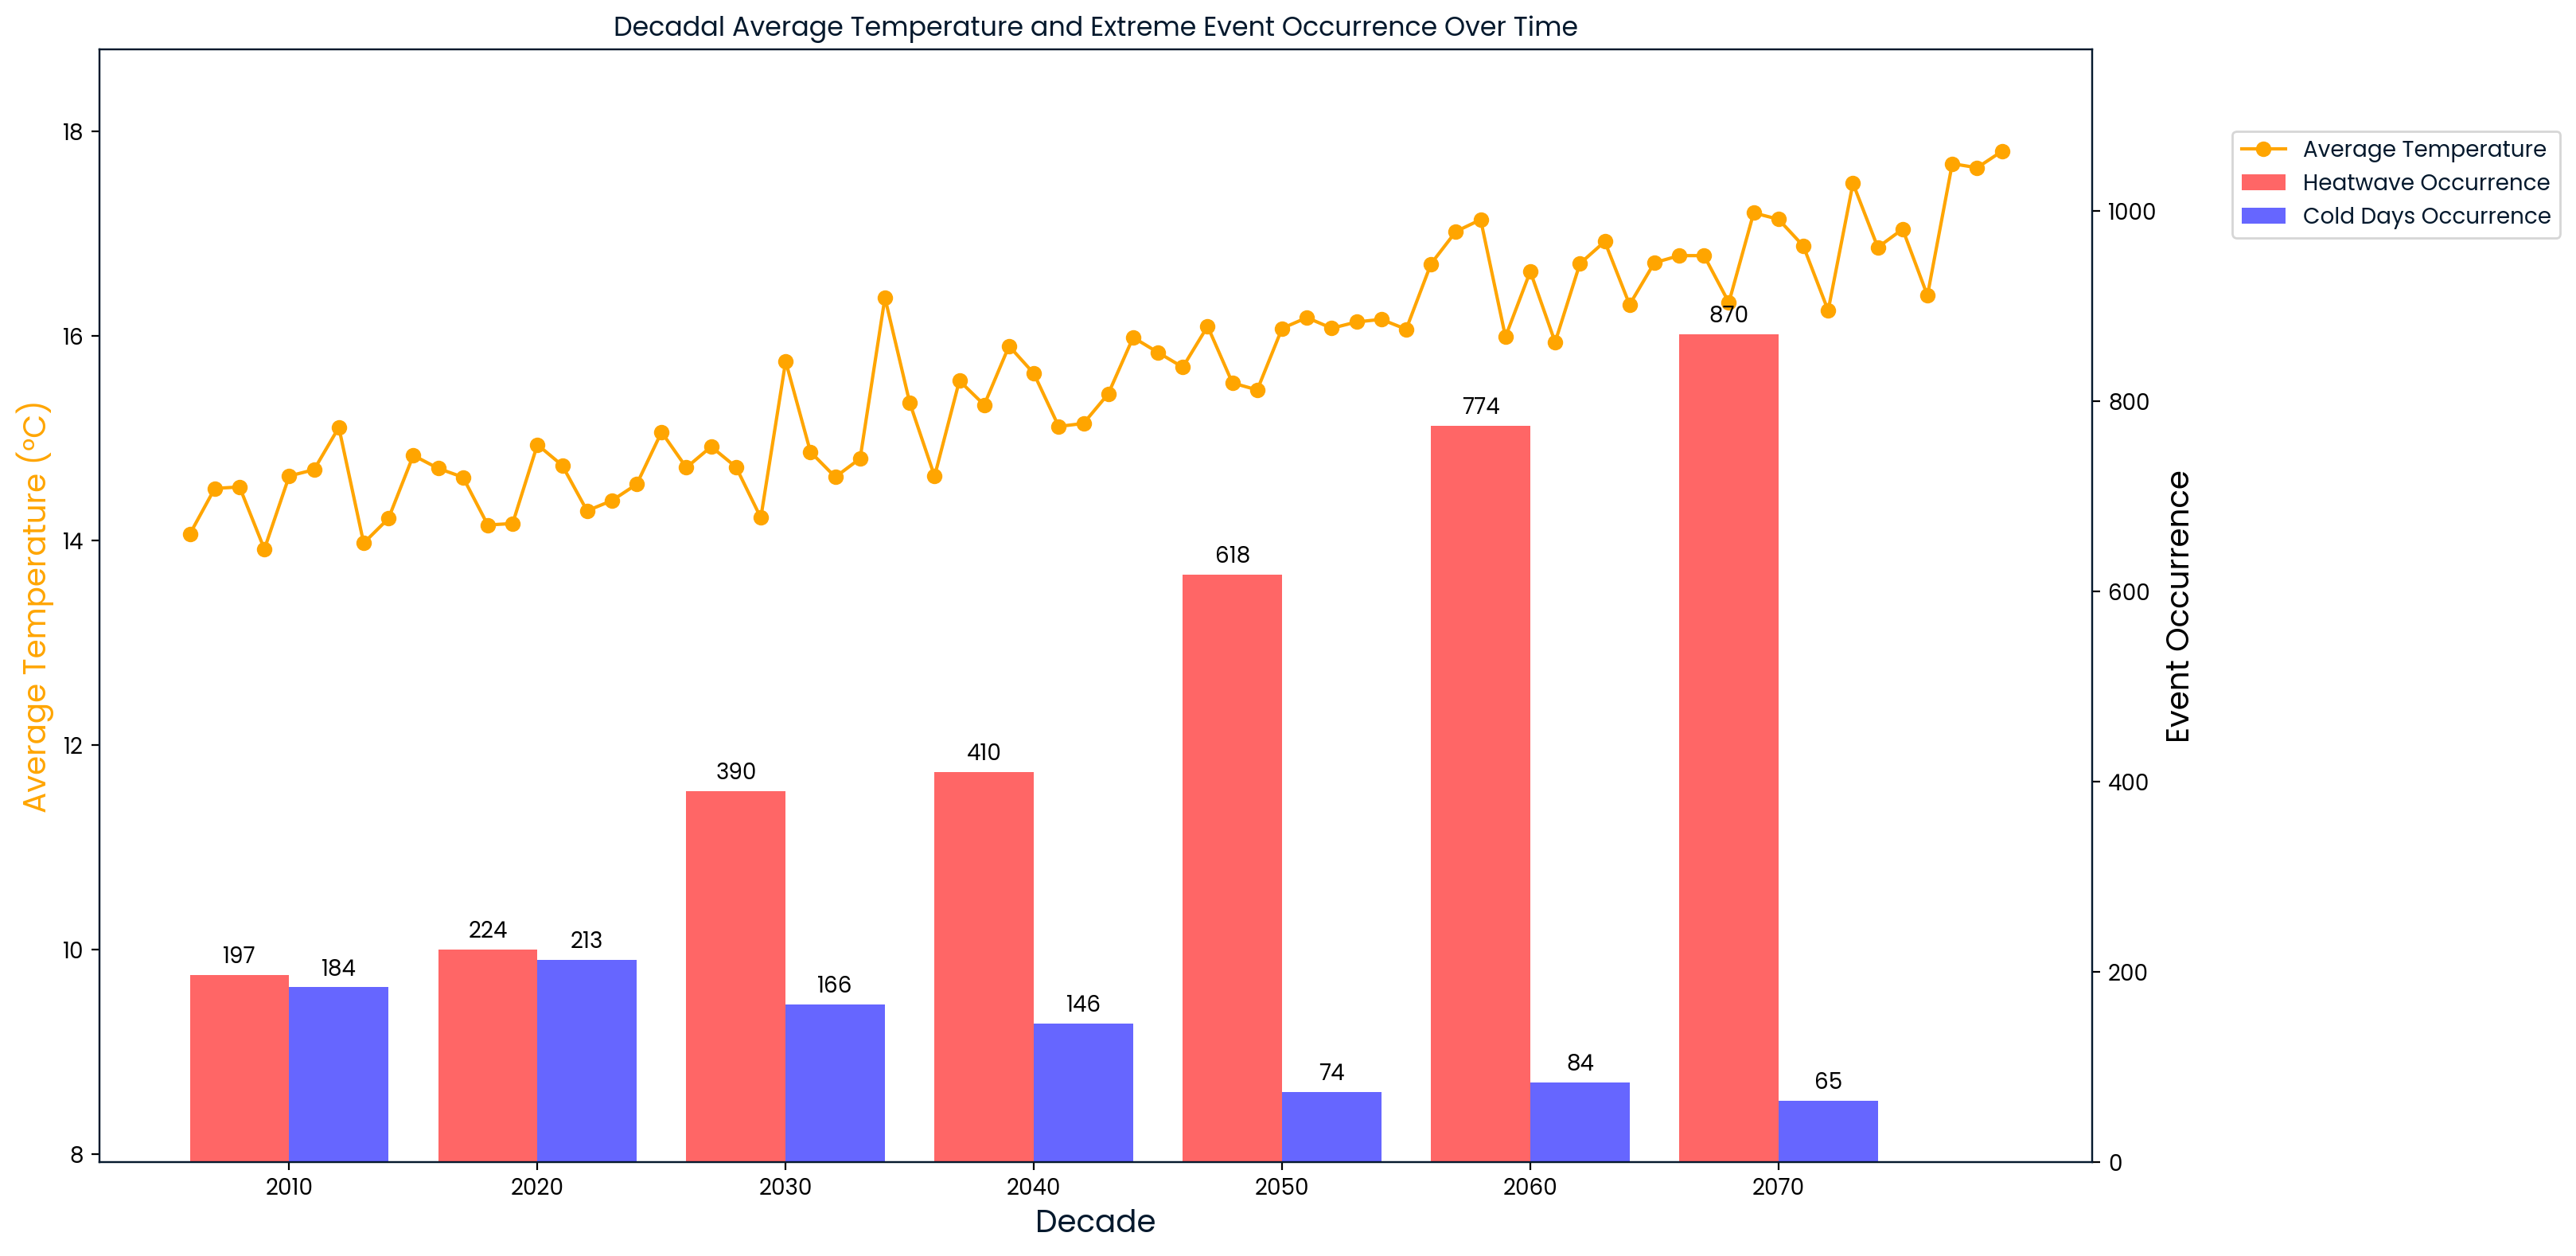

In [11]:
# Group by decade and calculate the average temperature for each decade
avg_temp_per_year = df.groupby('year')['TREFMXAV_U_C'].mean().reset_index()

# Group by decade and calculate the sum of heatwave occurrences for each decade
heatwave_per_decade = df.groupby('decade')['heatwave'].sum().reset_index()

# Group by decade and calculate the sum of cold days occurrences for each decade
cold_days_per_decade = df.groupby('decade')['cold_days'].sum().reset_index()

# Remove incomplete decades
avg_temp_per_year = avg_temp_per_year[~avg_temp_per_year['year'].isin([2000, 2080])]
heatwave_per_decade = heatwave_per_decade[~heatwave_per_decade['decade'].isin([2000, 2080])]
cold_days_per_decade = cold_days_per_decade[~cold_days_per_decade['decade'].isin([2000, 2080])]

# Create a figure and a set of subplots with twin y-axes
fig, ax1 = plt.subplots(figsize=(14, 8))

# Plot the average temperature on the left y-axis
ax1.plot(avg_temp_per_year['year'], avg_temp_per_year['TREFMXAV_U_C'], label='Average Temperature', color='orange', linestyle='-', marker='o')
ax1.set_xlabel('Decade', fontsize=14)
ax1.set_ylabel('Average Temperature (°C)', color='orange', fontsize=14)
ax1.tick_params(axis='y', labelcolor='orange')
ax1.tick_params(axis='x', colors='black')
ax1.tick_params(axis='y', colors='black')

# Create a second y-axis to plot the heatwave and cold days occurrences
ax2 = ax1.twinx()
bars_heatwave = ax2.bar(heatwave_per_decade['decade'] - 2, heatwave_per_decade['heatwave'], label='Heatwave Occurrence', color='red', alpha=0.6, width=4)
bars_cold_days = ax2.bar(cold_days_per_decade['decade'] + 2, cold_days_per_decade['cold_days'], label='Cold Days Occurrence', color='blue', alpha=0.6, width=4)
ax2.set_ylabel('Event Occurrence', color='black', fontsize=14)
ax2.tick_params(axis='y', labelcolor='black')
ax2.tick_params(axis='y', colors='black')

# Add data labels to the bars
for bar in bars_heatwave:
    height = bar.get_height()
    ax2.annotate(f'{height}',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),  # 3 points vertical offset
                 textcoords="offset points",
                 ha='center', va='bottom', color='black')

for bar in bars_cold_days:
    height = bar.get_height()
    ax2.annotate(f'{height}',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),  # 3 points vertical offset
                 textcoords="offset points",
                 ha='center', va='bottom', color='black')

# Scale the y-axes
ax1.set_ylim([avg_temp_per_year['TREFMXAV_U_C'].min() - 6, avg_temp_per_year['TREFMXAV_U_C'].max() + 1])
ax2.set_ylim([0, max(heatwave_per_decade['heatwave'].max(), cold_days_per_decade['cold_days'].max()) + 300])

# Remove 2080 from x-axis
ax1.set_xticks([decade for decade in heatwave_per_decade['decade'] if decade != 2080])

# Adding title and legend
plt.title('Decadal Average Temperature and Extreme Event Occurrence Over Time')
fig.tight_layout()

# Add legend
fig.legend(loc='upper left', bbox_to_anchor=(1, 0.9))

# Display the plot
plt.show()

In [12]:
# Calculate the temperature increase percentage from 2006 to 2079 using avg_temp_per_year
temp_2006 = avg_temp_per_year[avg_temp_per_year['year'] == 2006]['TREFMXAV_U_C'].values[0]
temp_2079 = avg_temp_per_year[avg_temp_per_year['year'] == 2079]['TREFMXAV_U_C'].values[0]

# Calculate the percentage increase
temp_increase_percentage = ((temp_2079 - temp_2006) / temp_2006) * 100

# Print the result
print(f"Temperature increase from 2006 to 2079: {temp_increase_percentage:.2f}%")

Temperature increase from 2006 to 2079: 26.61%


In [13]:
# Calculate the proportion of increase of heatwave events from 2010s to 2070s using heatwave_per_decade
heatwave_2010s = heatwave_per_decade[heatwave_per_decade['decade'] == 2010]['heatwave'].values[0]
heatwave_2070s = heatwave_per_decade[heatwave_per_decade['decade'] == 2070]['heatwave'].values[0]

# Calculate the proportion increase
heatwave_increase_proportion = ((heatwave_2070s) / heatwave_2010s)

# Print the result
print(f"Proportion of increase of heatwave events from 2010s to 2070s: x{heatwave_increase_proportion:.2f}")

Proportion of increase of heatwave events from 2010s to 2070s: x4.42


## 5. Drivers and Correlation Analysis

In [14]:
df.set_index('time', inplace=True)

In [16]:
# Define parameters and events
numeric_cols = ['TREFMXAV_U_C', 'FLNS', 'FSNS', 'PRECT', 'PRSN', 'QBOT',
               'TREFHT_C', 'UBOT', 'VBOT', 'UVBOT']
events = ['heatwave', 'cold_days', 'heavy_precipitation', 'strong_winds']
palette = {'Extreme': '#ff7f0e', 'Normal': '#1f77b4'}

1. **Extreme Event Analysis (`analyze_extreme_event`)**  
   Performs a multi-faceted analysis of extreme weather events through:  
   - **Mean Comparison**: Quantifies differences in meteorological variables between extreme and normal days via horizontal bar charts with significance markers (`*** p<0.001`, `** p<0.01`, `* p<0.05`)  
   - **Distribution Comparison**: Visualizes parameter distributions (e.g., humidity `QBOT`) between event/normal days using violin plots  
   - **Quartile Analysis**: Analyzes event occurrence rates across parameter quartiles to identify threshold effects  
   - **Statistical Reporting**: Returns a DataFrame with mean values, differences, percentage changes, and Welch's t-test p-values  

2. **Core Functionality**  
   - Automated data segmentation into extreme/normal groups  
   - Multi-panel visualization (2x2 grid) for holistic analysis  
   - Dynamic significance annotation based on statistical thresholds  
   - Batch processing support through event iteration  
   - High-resolution image output (`_mean_diff_QBOT_analysis.png`)  

3. **Technical Implementation**  
   - GridSpec layout for complex plot arrangement  
   - Welch's t-test for unequal variance comparisons  
   - Quartile-based event probability calculation  
   - Color-coded visualization using predefined palette  
   - Automated result formatting and sorting by significance  


Analyzing HEATWAVE:
[0.0, 2.3986406186028502e-293, 0.0, 2.5687346875795982e-263, 8.895237213178673e-27, 0.0, 0.0, 3.060342376205549e-190, 6.95702841085041e-239, 0.0]


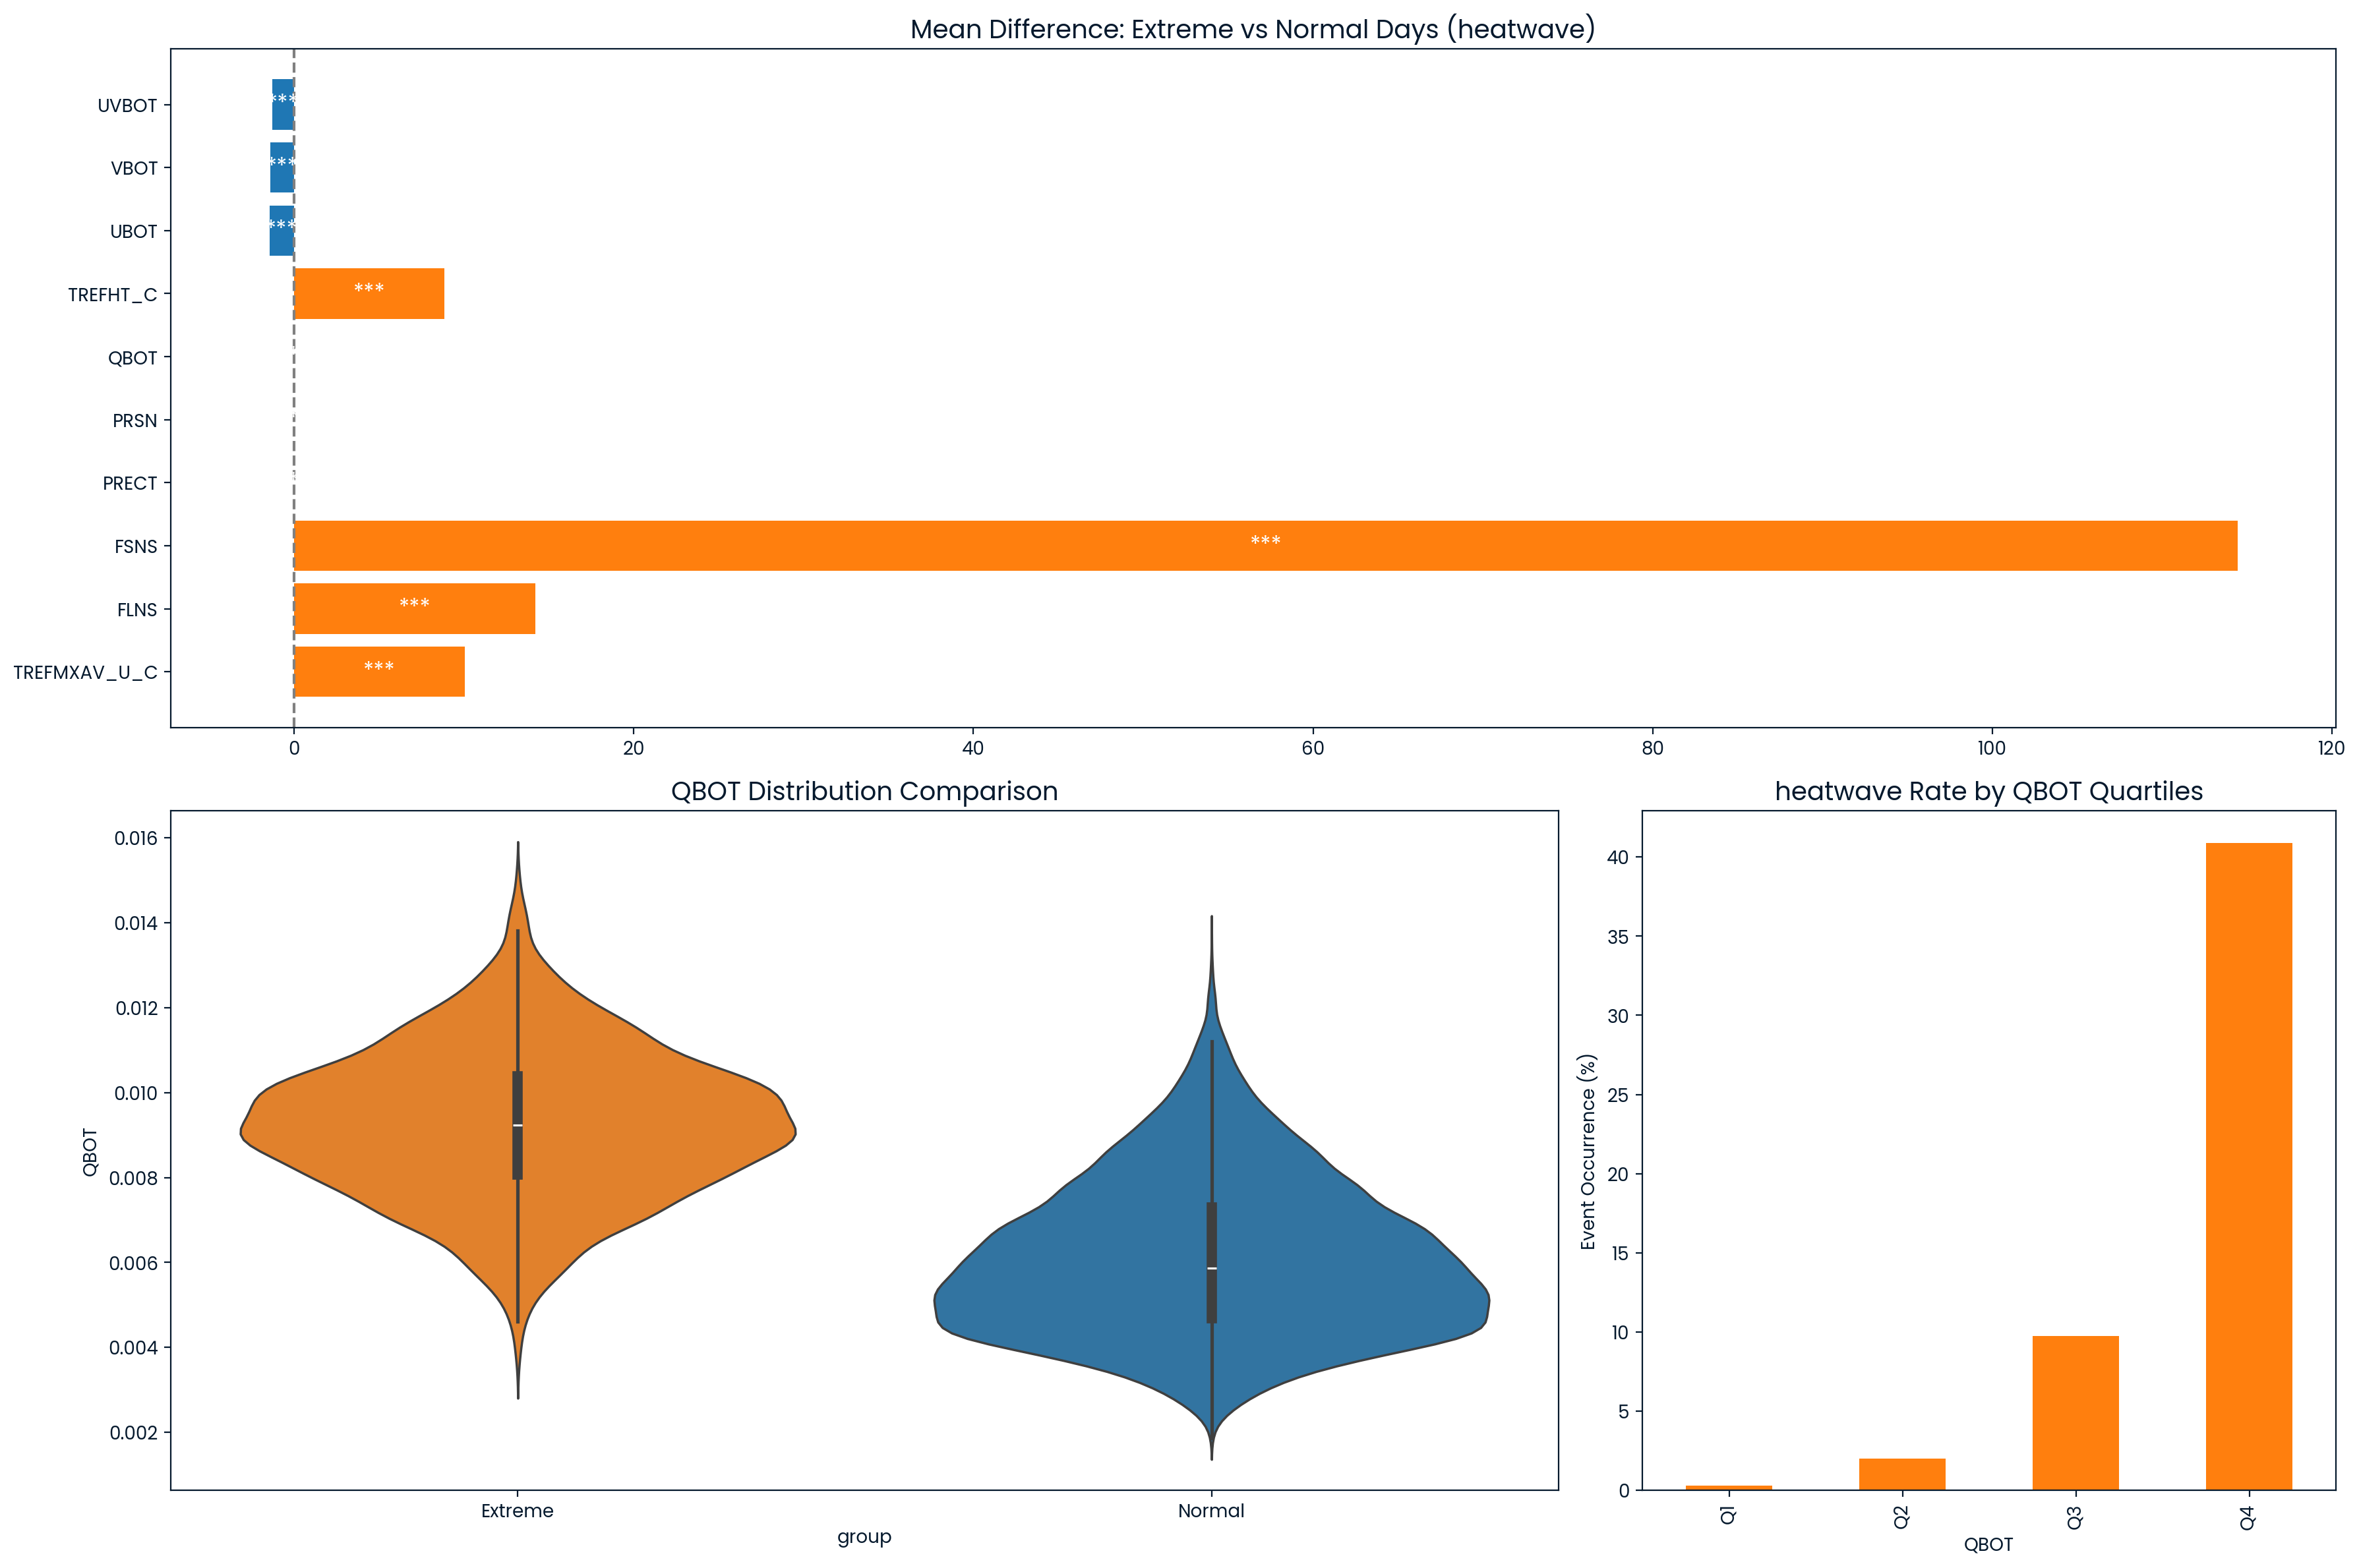

,Extreme_Mean,Normal_Mean,Mean_Diff,Percent_Change,P_Value
TREFMXAV_U_C,24.4065,14.3568,10.0496,69.9991,0.0
FSNS,196.3350,81.8873,114.4477,139.7626,0.0
QBOT,0.0093,0.0061,0.0031,51.4885,0.0
TREFHT_C,19.3890,10.5583,8.8307,83.6372,0.0
UVBOT,3.1381,4.4305,-1.2924,-29.1697,0.0
FLNS,55.3297,41.1154,14.2143,34.5717,0.0
PRECT,0.0000,0.0000,-0.0000,-56.8266,0.0
VBOT,0.2887,1.6882,-1.3995,-82.8968,0.0
UBOT,-0.0906,1.3695,-1.4601,-106.6179,0.0
PRSN,0.0000,0.0000,-0.0000,-99.9982,0.0



Analyzing COLD_DAYS:
[0.0, 1.0263285617994912e-89, 3.1221657900133263e-287, 3.253269516616117e-40, 5.801819731043914e-19, 0.0, 0.0, 5.327717186031534e-24, 1.468204343675937e-117, 1.122588998756675e-26]


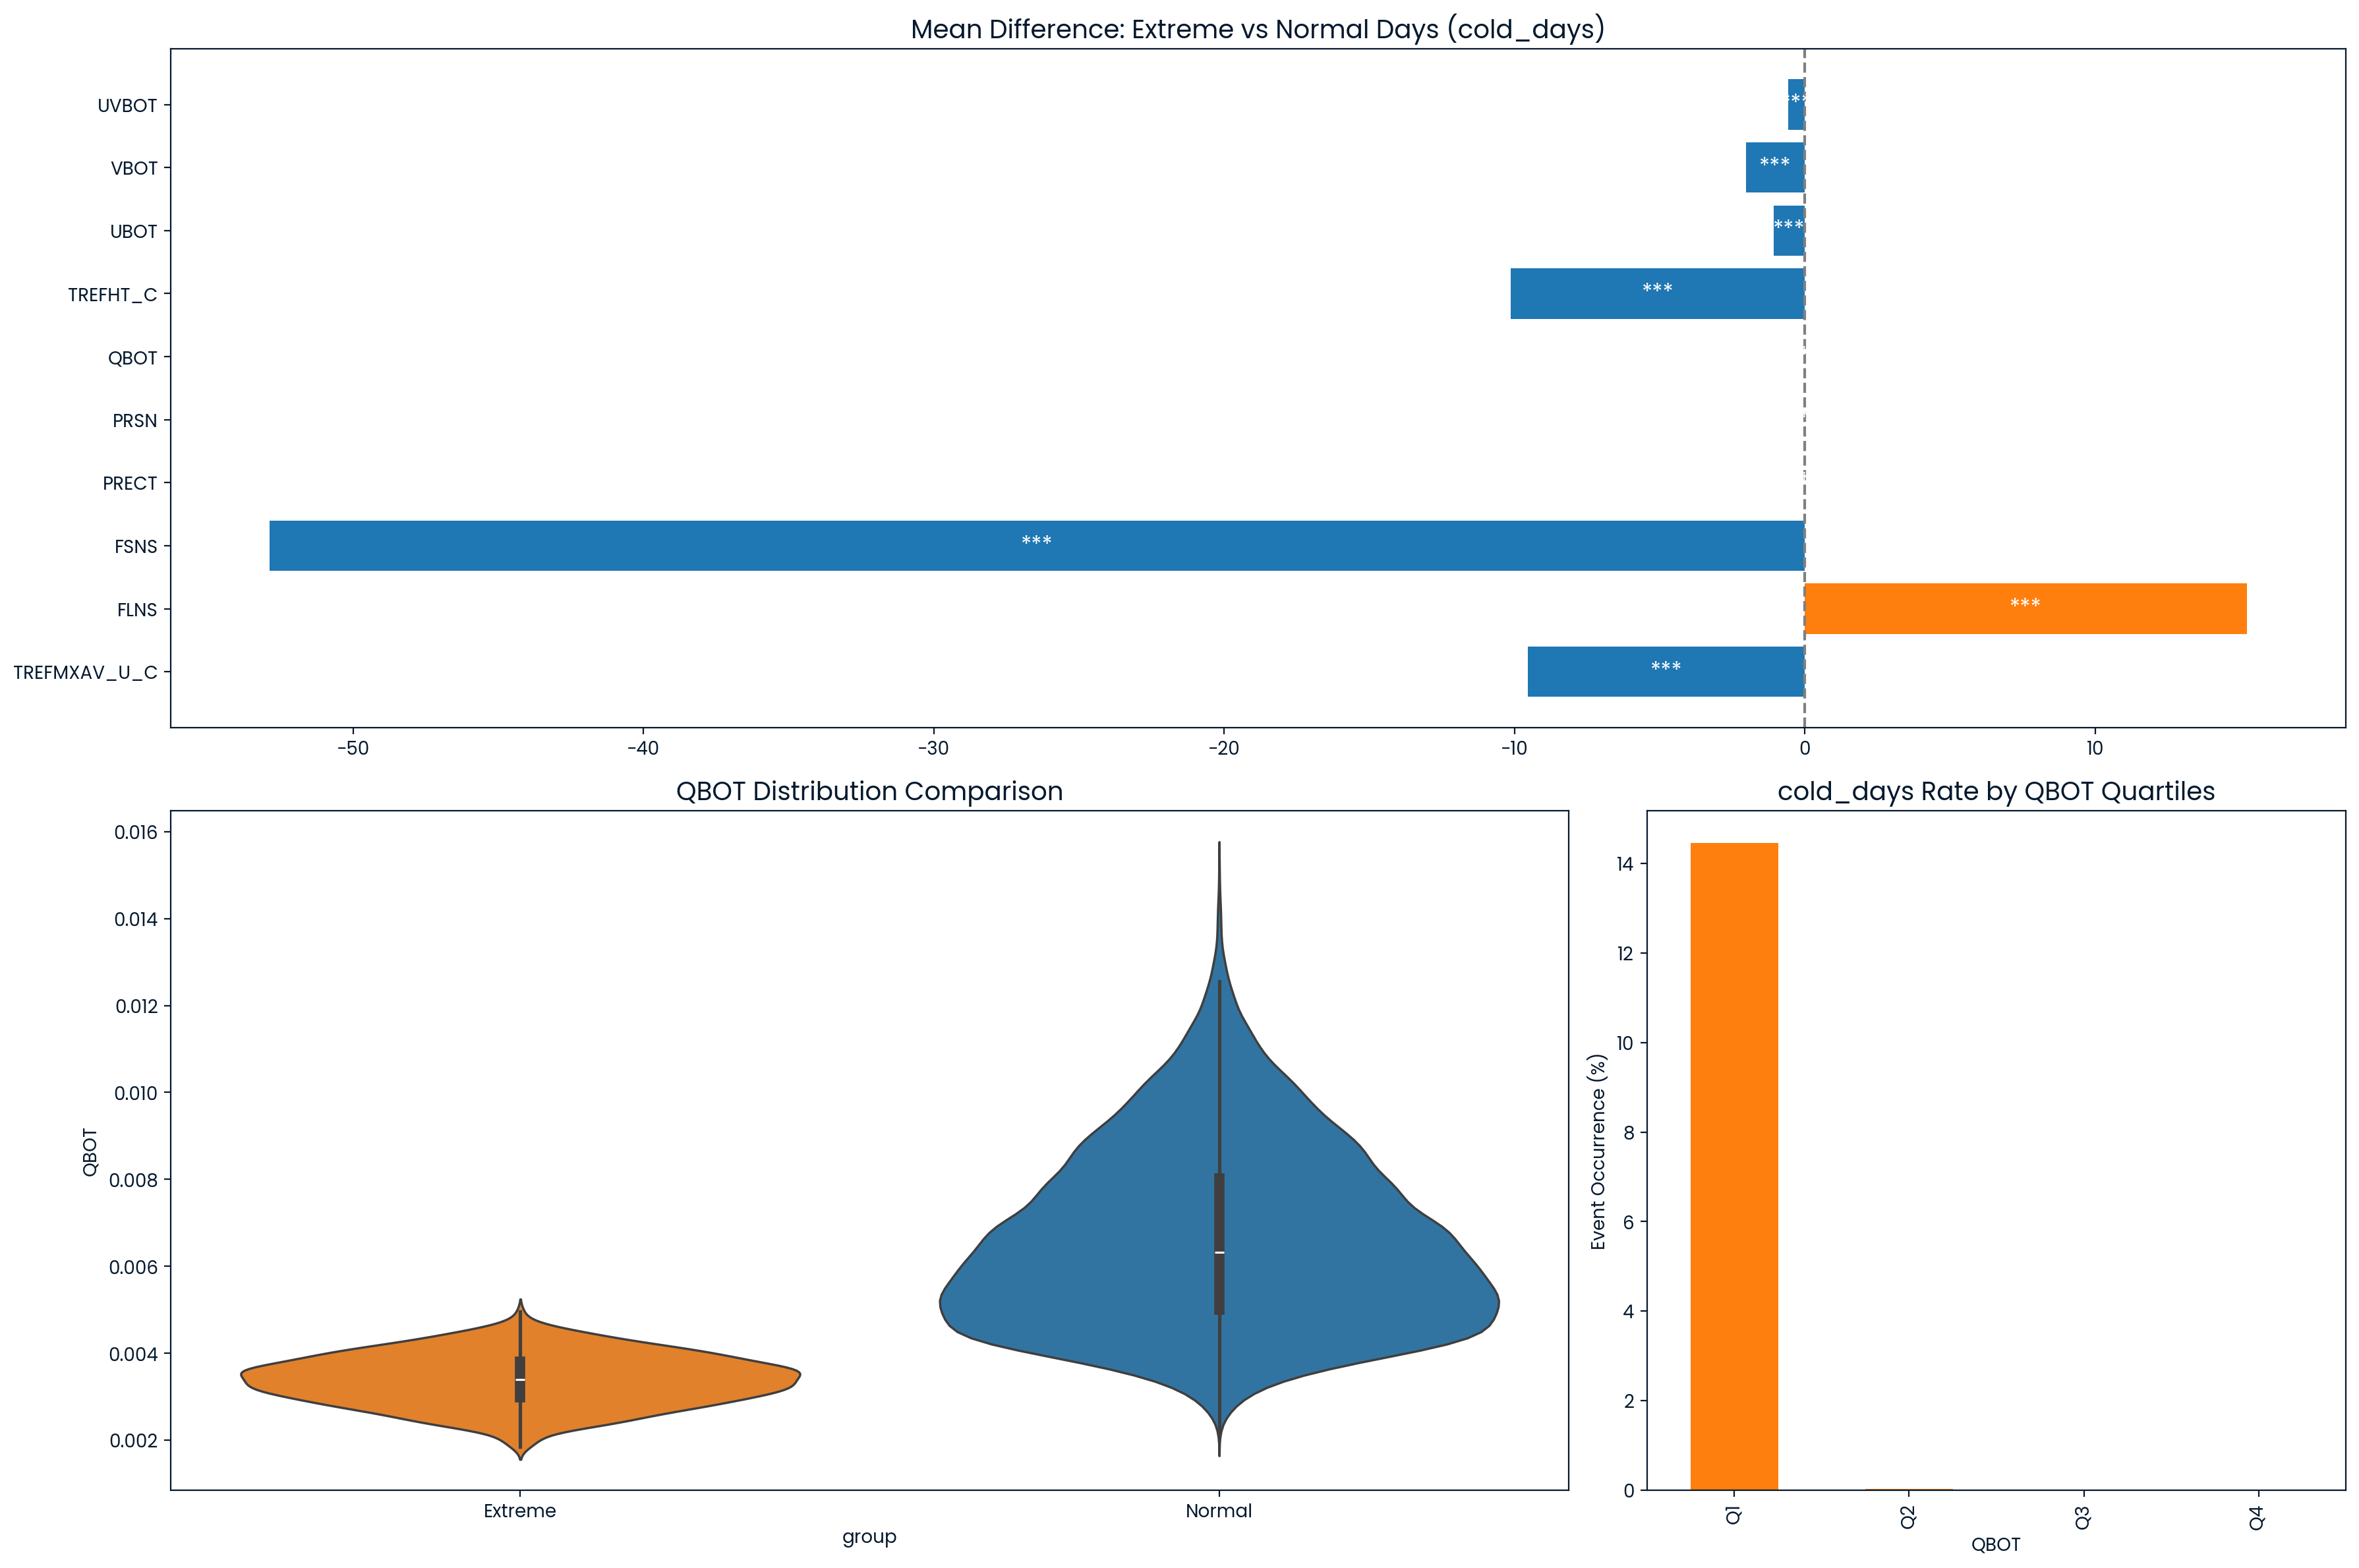

,Extreme_Mean,Normal_Mean,Mean_Diff,Percent_Change,P_Value
TREFMXAV_U_C,6.4921,16.0315,-9.5394,-59.5043,0.0
QBOT,0.0034,0.0066,-0.0033,-48.9645,0.0
TREFHT_C,1.9559,12.0934,-10.1375,-83.8266,0.0
FSNS,46.0706,98.9403,-52.8697,-53.4360,0.0
VBOT,-0.4530,1.5766,-2.0296,-128.7340,0.0
FLNS,57.6757,42.4443,15.2314,35.8857,0.0
PRECT,0.0000,0.0000,-0.0000,-49.3443,0.0
UVBOT,3.7082,4.2803,-0.5721,-13.3657,0.0
UBOT,0.1350,1.2154,-1.0805,-88.8945,0.0
PRSN,0.0000,0.0000,0.0000,8729.2813,0.0



Analyzing HEAVY_PRECIPITATION:
[5.146005822012633e-24, 0.0, 0.0, 0.0, 1.5062897567547554e-07, 1.421344303215104e-90, 0.009521838954637695, 4.307957564891565e-25, 4.268690752439311e-32, 6.735719587217985e-24]


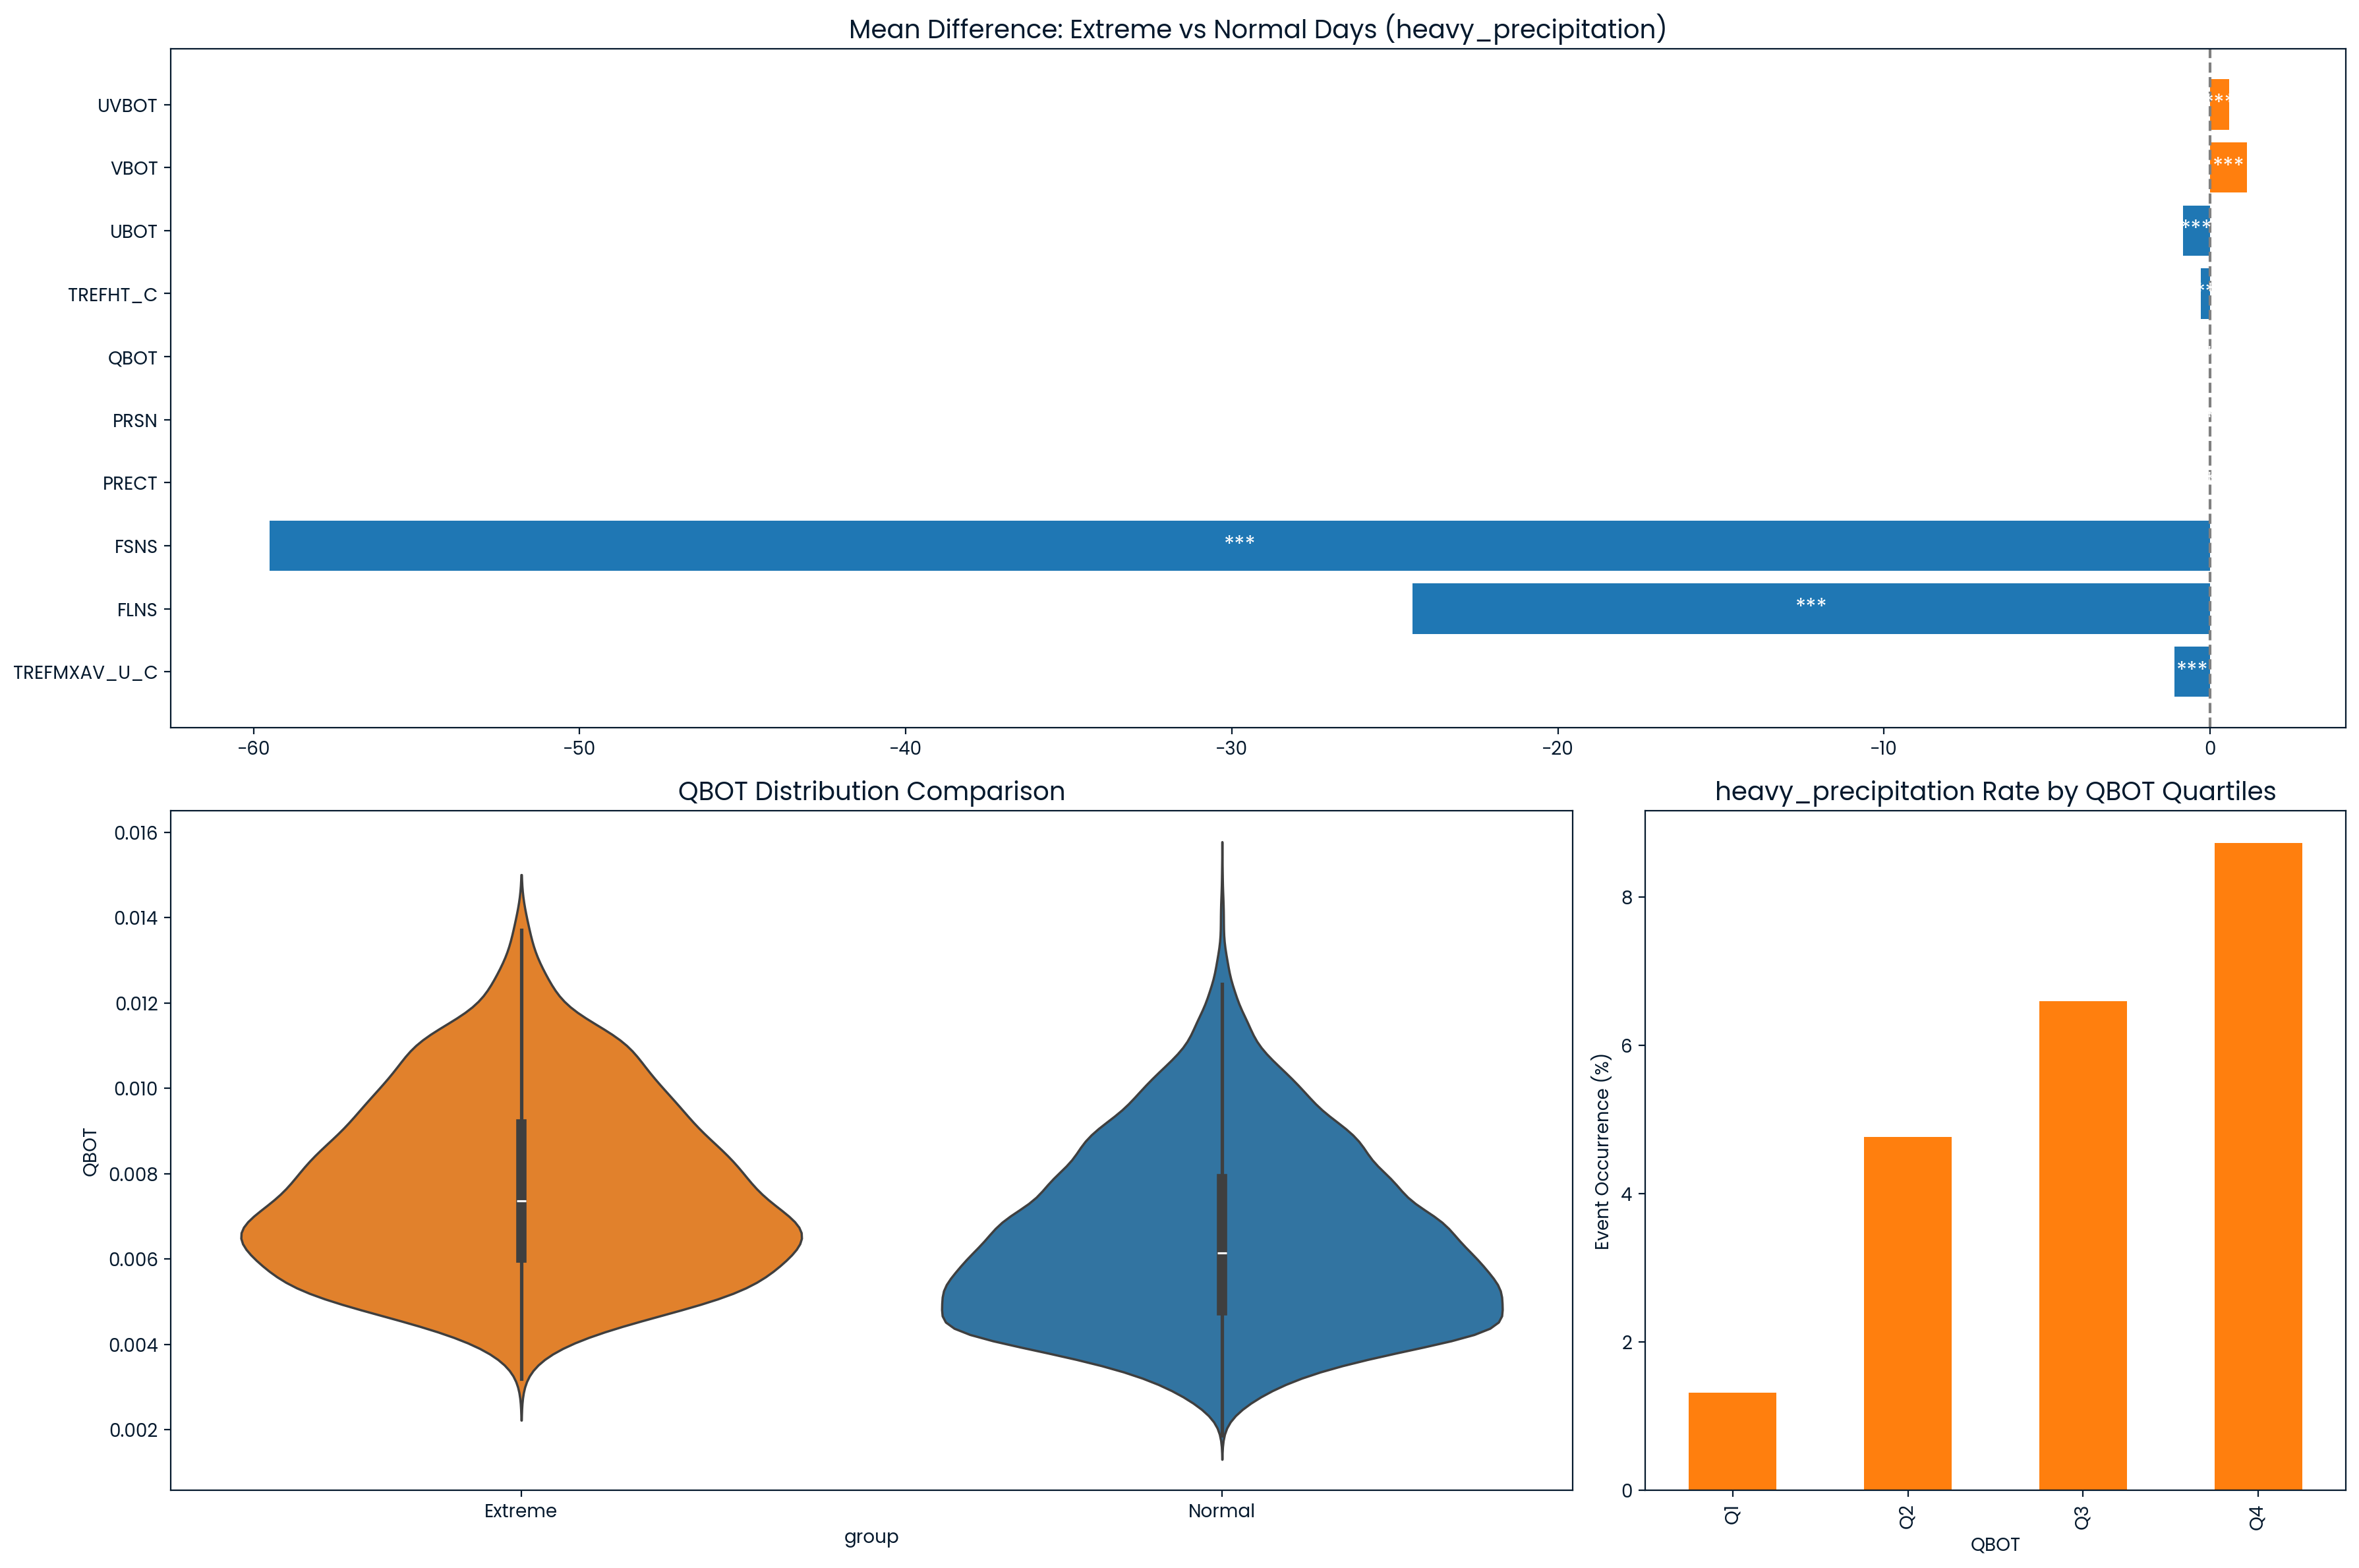

,Extreme_Mean,Normal_Mean,Mean_Diff,Percent_Change,P_Value
FLNS,19.8537,44.3033,-24.4496,-55.1869,0.0000
FSNS,40.7058,100.2085,-59.5027,-59.3789,0.0000
PRECT,0.0000,0.0000,0.0000,656.7658,0.0000
QBOT,0.0077,0.0065,0.0012,18.6253,0.0000
VBOT,2.5786,1.4423,1.1363,78.7806,0.0000
UBOT,0.3935,1.2206,-0.8270,-67.7589,0.0000
TREFMXAV_U_C,14.6515,15.7446,-1.0932,-6.9431,0.0000
UVBOT,4.8166,4.2281,0.5886,13.9202,0.0000
PRSN,0.0000,0.0000,0.0000,1188.7092,0.0000
TREFHT_C,11.4528,11.7419,-0.2891,-2.4620,0.0095



Analyzing STRONG_WINDS:
[8.73988888785997e-285, 5.3268152679100645e-115, 0.0, 2.302960460076982e-79, 0.19912133567220489, 1.8947234775948148e-117, 3.951471831966926e-163, 2.708389766311407e-226, 0.0, 0.0]


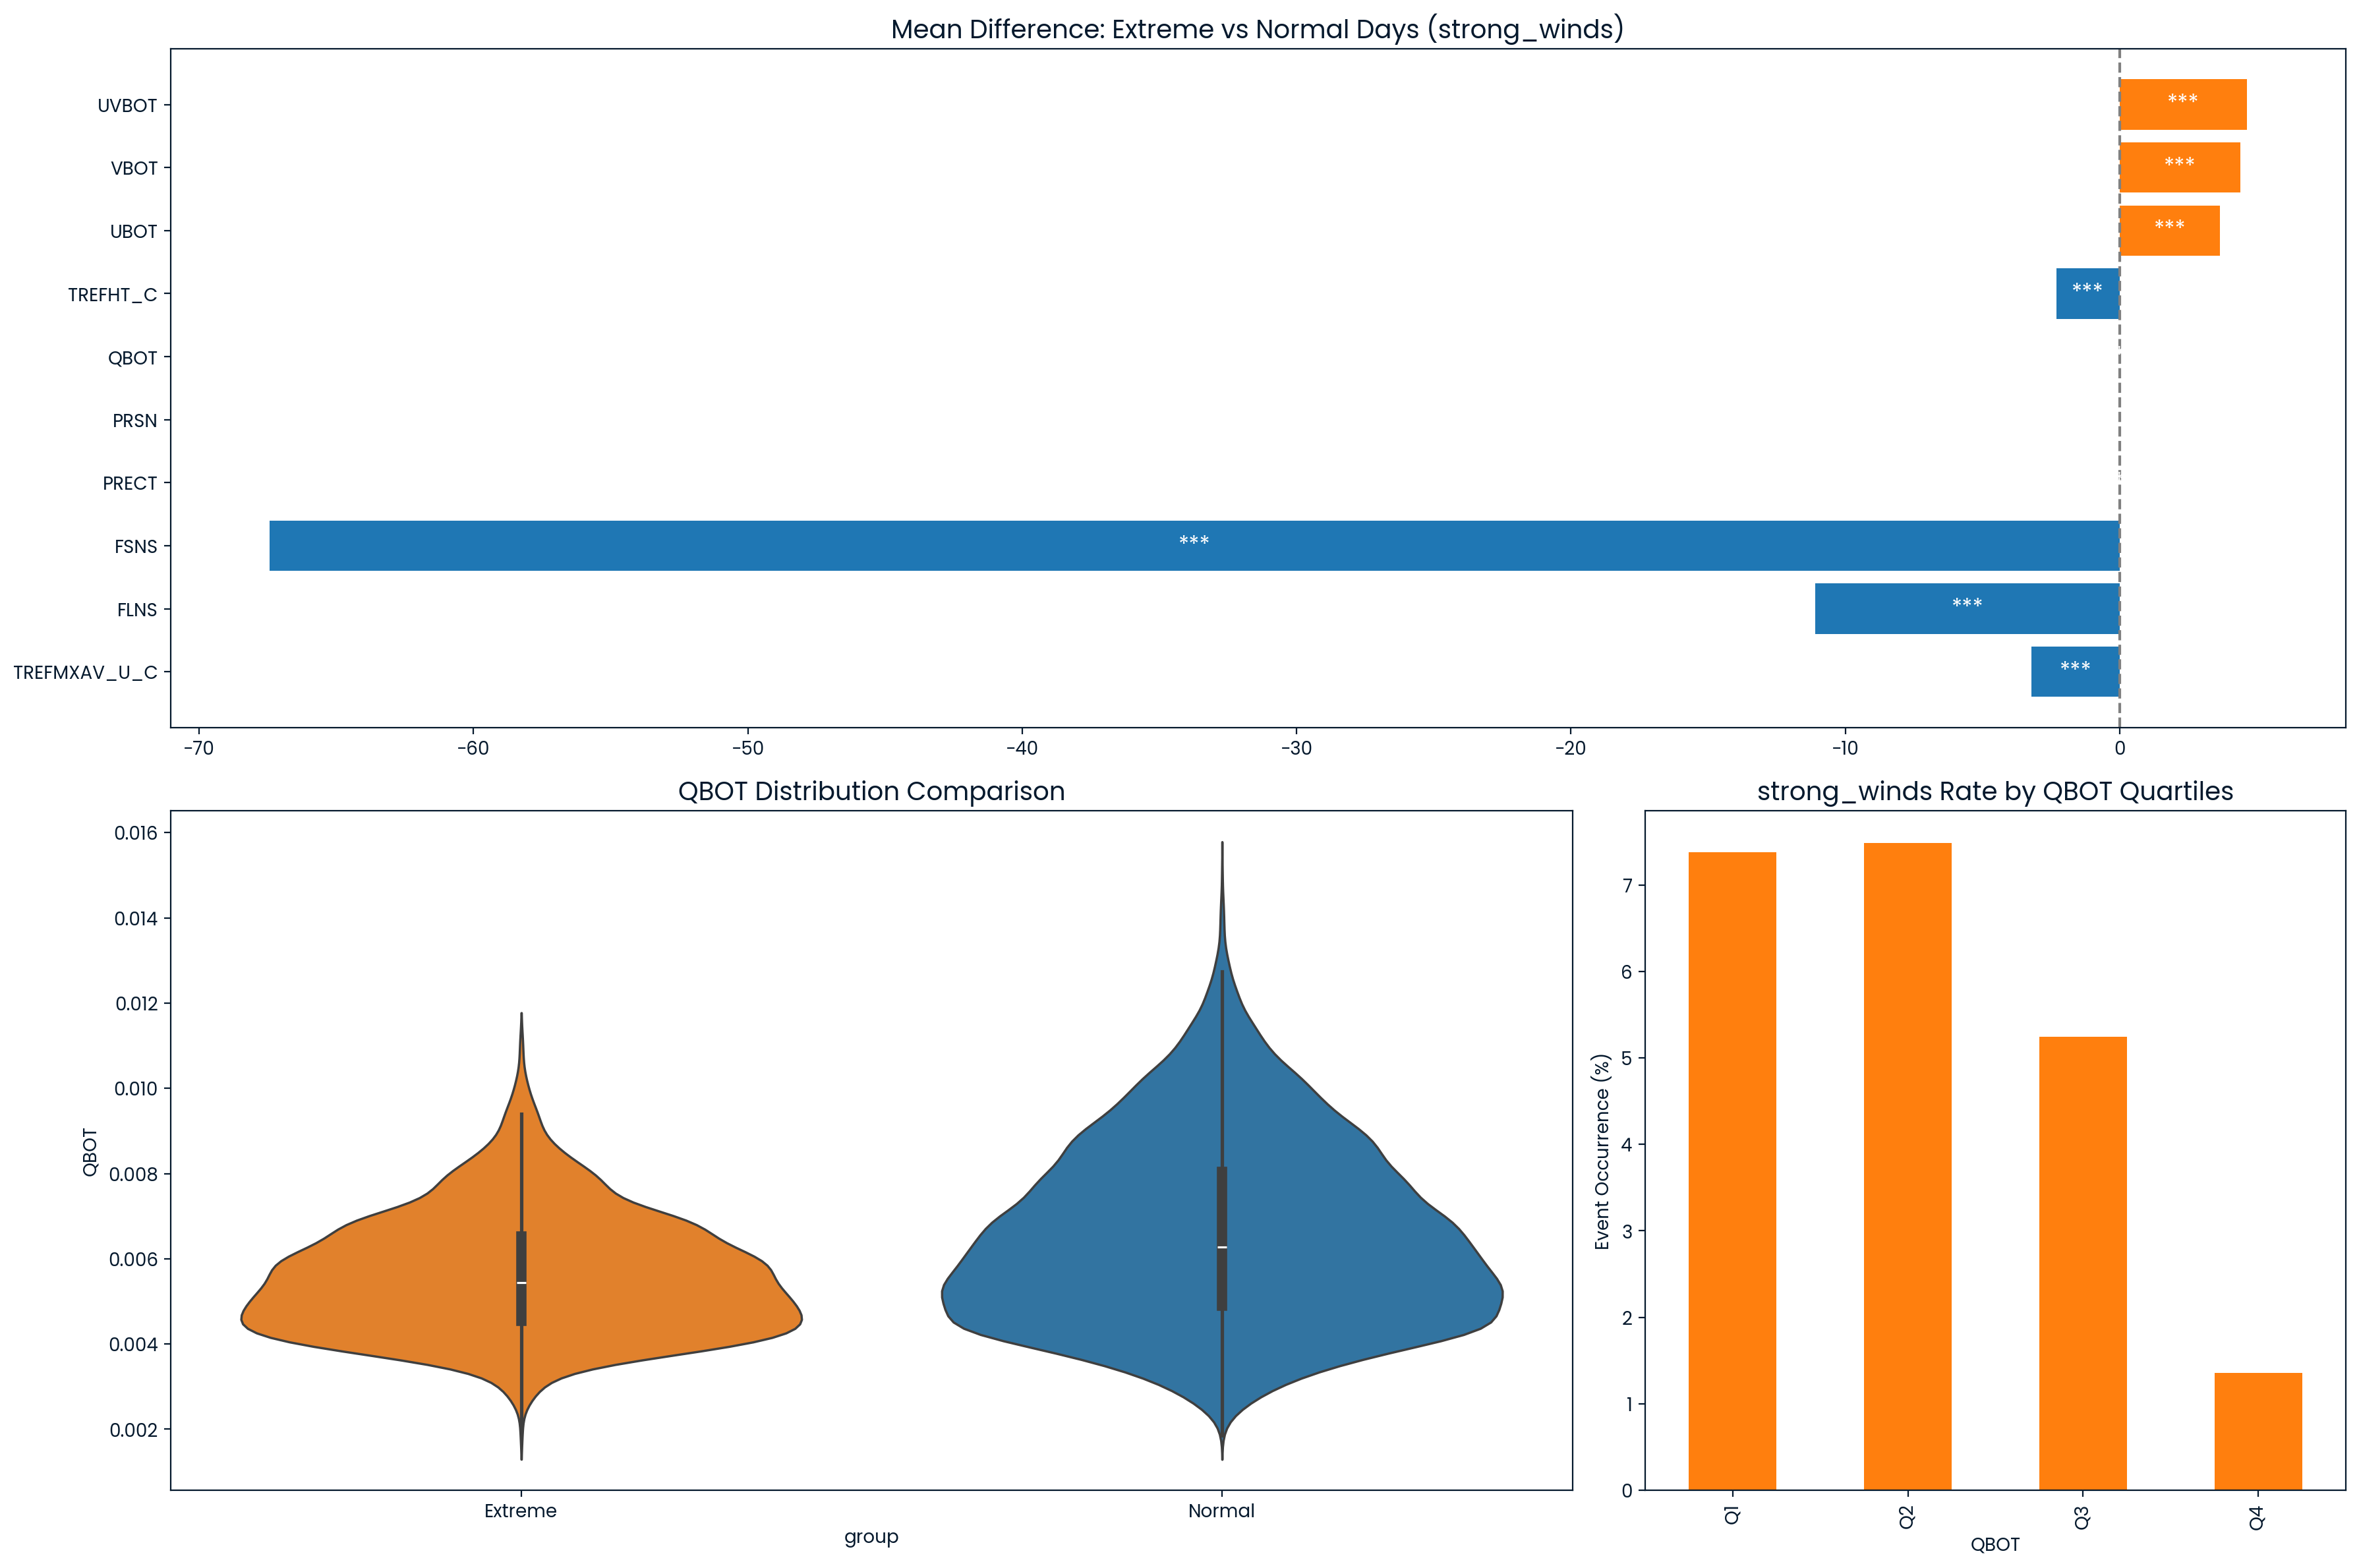

,Extreme_Mean,Normal_Mean,Mean_Diff,Percent_Change,P_Value
FSNS,33.2179,100.6447,-67.4268,-66.9949,0.0000
VBOT,5.6700,1.2668,4.4033,347.5924,0.0000
UVBOT,8.6506,4.0106,4.6400,115.6954,0.0000
TREFMXAV_U_C,12.6513,15.8583,-3.2070,-20.2227,0.0000
UBOT,4.6360,0.9801,3.6559,373.0017,0.0000
TREFHT_C,9.5363,11.8506,-2.3143,-19.5289,0.0000
QBOT,0.0056,0.0066,-0.0010,-14.5318,0.0000
FLNS,32.4913,43.5914,-11.1000,-25.4638,0.0000
PRECT,0.0000,0.0000,0.0000,94.5980,0.0000
PRSN,0.0000,0.0000,-0.0000,-39.4614,0.1991


In [17]:
def analyze_extreme_event(event_name):
    # Data splitting
    extreme_days = df[df[event_name]]
    normal_days = df[~df[event_name]]
    
    # Create figure layout
    plt.figure(figsize=(18, 12))
    gs = gridspec.GridSpec(2, 2, width_ratios=[2, 1])
    
    # Plot 1: Mean comparison with significance markers
    ax1 = plt.subplot(gs[0, :])
    mean_diff = (extreme_days[numeric_cols].mean() - normal_days[numeric_cols].mean())
    p_values = [stats.ttest_ind(extreme_days[col], normal_days[col], equal_var=False)[1] 
                for col in numeric_cols]
    
    print(p_values)
    
    bars = ax1.barh(numeric_cols, mean_diff, color=np.where(mean_diff > 0, palette['Extreme'], palette['Normal']))
    for i, (p, bar) in enumerate(zip(p_values, bars)):
        # Determine significance stars
        if p < 0.001:
            stars = '***'
        elif p < 0.01:
            stars = '**'
        elif p < 0.05:
            stars = '*'
        else:
            continue
            
        ax1.text(bar.get_width()/2, 
                bar.get_y() + bar.get_height()/2, 
                stars, 
                ha='center', 
                va='center', 
                color='white', 
                fontsize=12)
    
    ax1.set_title(f'Mean Difference: Extreme vs Normal Days ({event_name})', fontsize=14)
    ax1.axvline(0, color='gray', linestyle='--')
    
    # Plot 2: Distribution comparison (example parameter)
    ax2 = plt.subplot(gs[1, 0])
    example_param = 'QBOT'  # Can be parameterized
    combined_data = pd.concat([
        extreme_days[[example_param]].assign(group='Extreme'),
        normal_days[[example_param]].assign(group='Normal')
    ])
    sns.violinplot(x='group', y=example_param, data=combined_data, 
                  palette=palette, ax=ax2)
    ax2.set_title(f'{example_param} Distribution Comparison', fontsize=14)
    
    # Plot 3: Event occurrence by parameter quartiles
    ax3 = plt.subplot(gs[1, 1])
    param_quartiles = pd.qcut(df['QBOT'], 4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
    event_rate = df.groupby(param_quartiles)[event_name].mean() * 100
    event_rate.plot(kind='bar', color=palette['Extreme'], ax=ax3)
    ax3.set_title(f'{event_name} Rate by QBOT Quartiles', fontsize=14)
    ax3.set_ylabel('Event Occurrence (%)')
    
    plt.tight_layout()
    filename = f"{event_name}_mean_diff_QBOT_analysis.png"
    plt.savefig(filename, bbox_inches='tight', dpi=300)
    plt.show()
    
    # Return statistical results
    results = pd.DataFrame({
        'Extreme_Mean': extreme_days[numeric_cols].mean(),
        'Normal_Mean': normal_days[numeric_cols].mean(),
        'Mean_Diff': mean_diff,
        'Percent_Change': (mean_diff / normal_days[numeric_cols].mean()) * 100,
        'P_Value': p_values
    })
    return results.sort_values('P_Value')

# Analyze all events
for event in events:
    print(f"\n{'='*40}\nAnalyzing {event.upper()}:\n{'='*40}")
    results = analyze_extreme_event(event)
    display(results.round(4))

1. **Variables vs Events Correlation Analysis (`event_correlation.png`):**  
   Calculates and visualizes Pearson correlation coefficients between meteorological variables and extreme event occurrences using a heatmap. Identifies key drivers of specific events by showing directional relationships (positive/negative correlations) between atmospheric conditions (temperature, humidity, wind, etc.) and event frequencies.

2. **Inter-Variable Correlation Matrix (`variable_correlation_matrix.png`):**  
   Generates a triangular correlation matrix heatmap to examine pairwise relationships between meteorological variables. Detects multicollinearity between predictors and reveals underlying atmospheric interaction patterns by masking redundant upper triangle values, focusing on essential variable couplings.

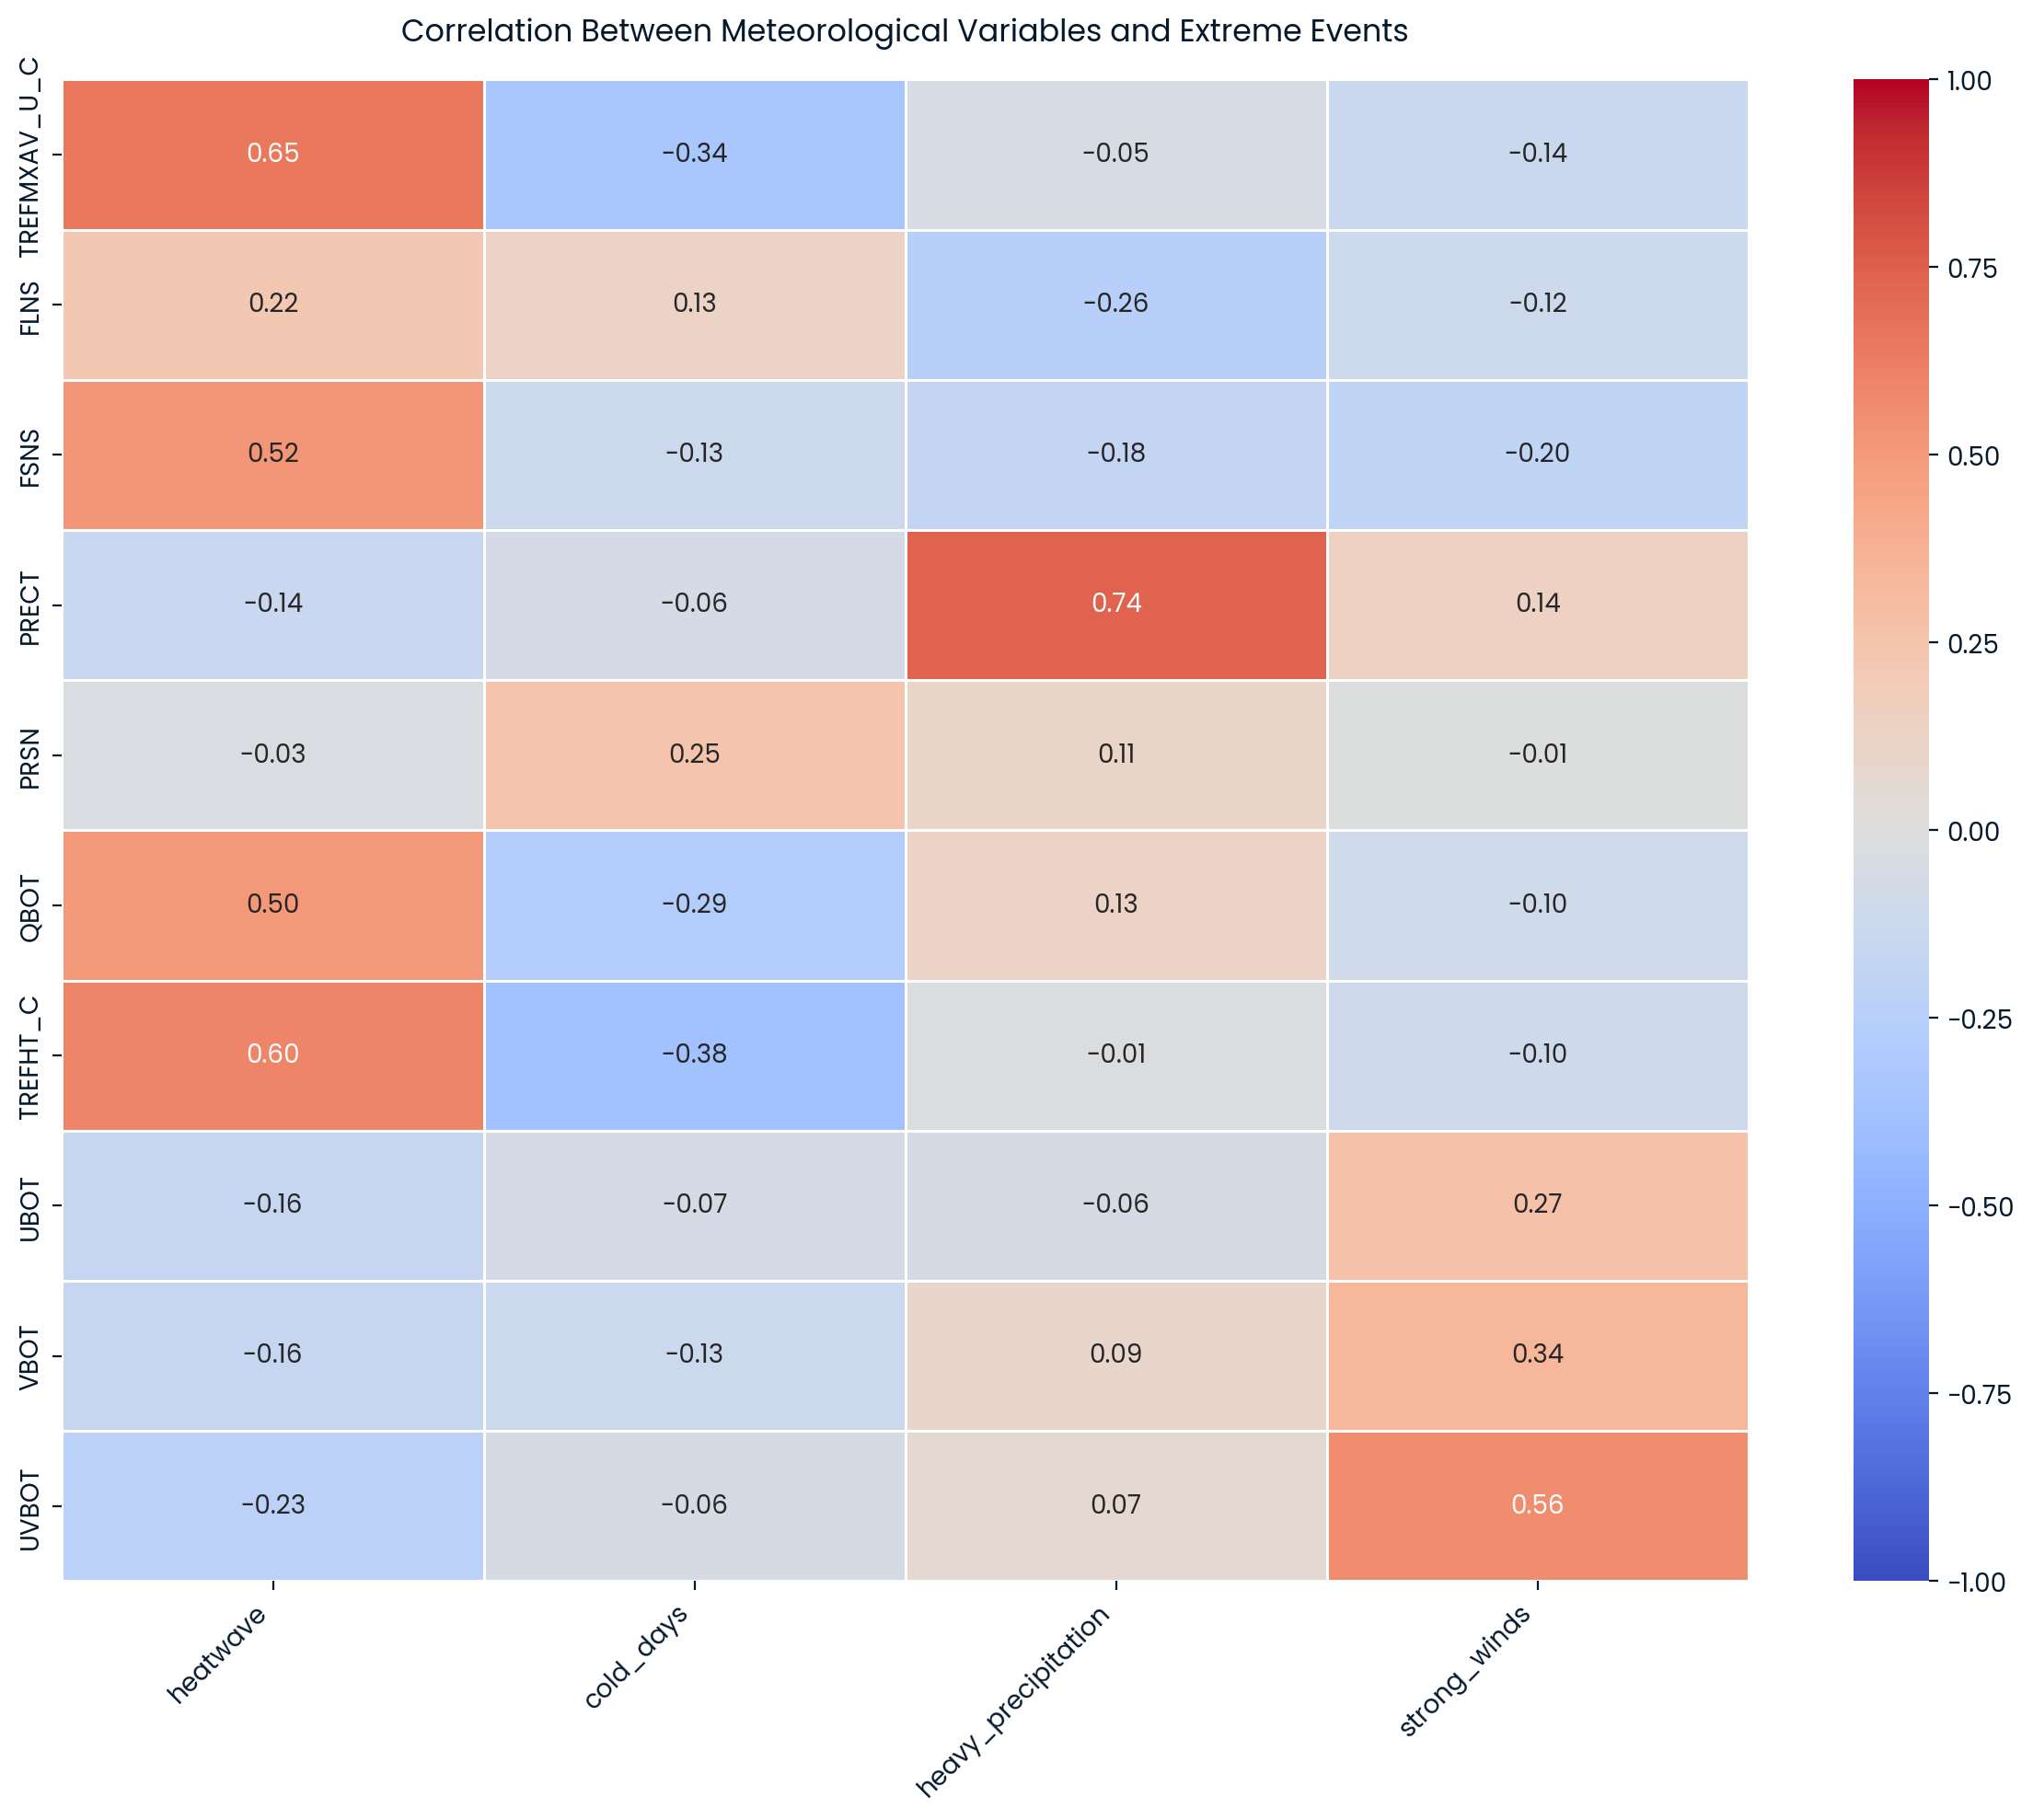

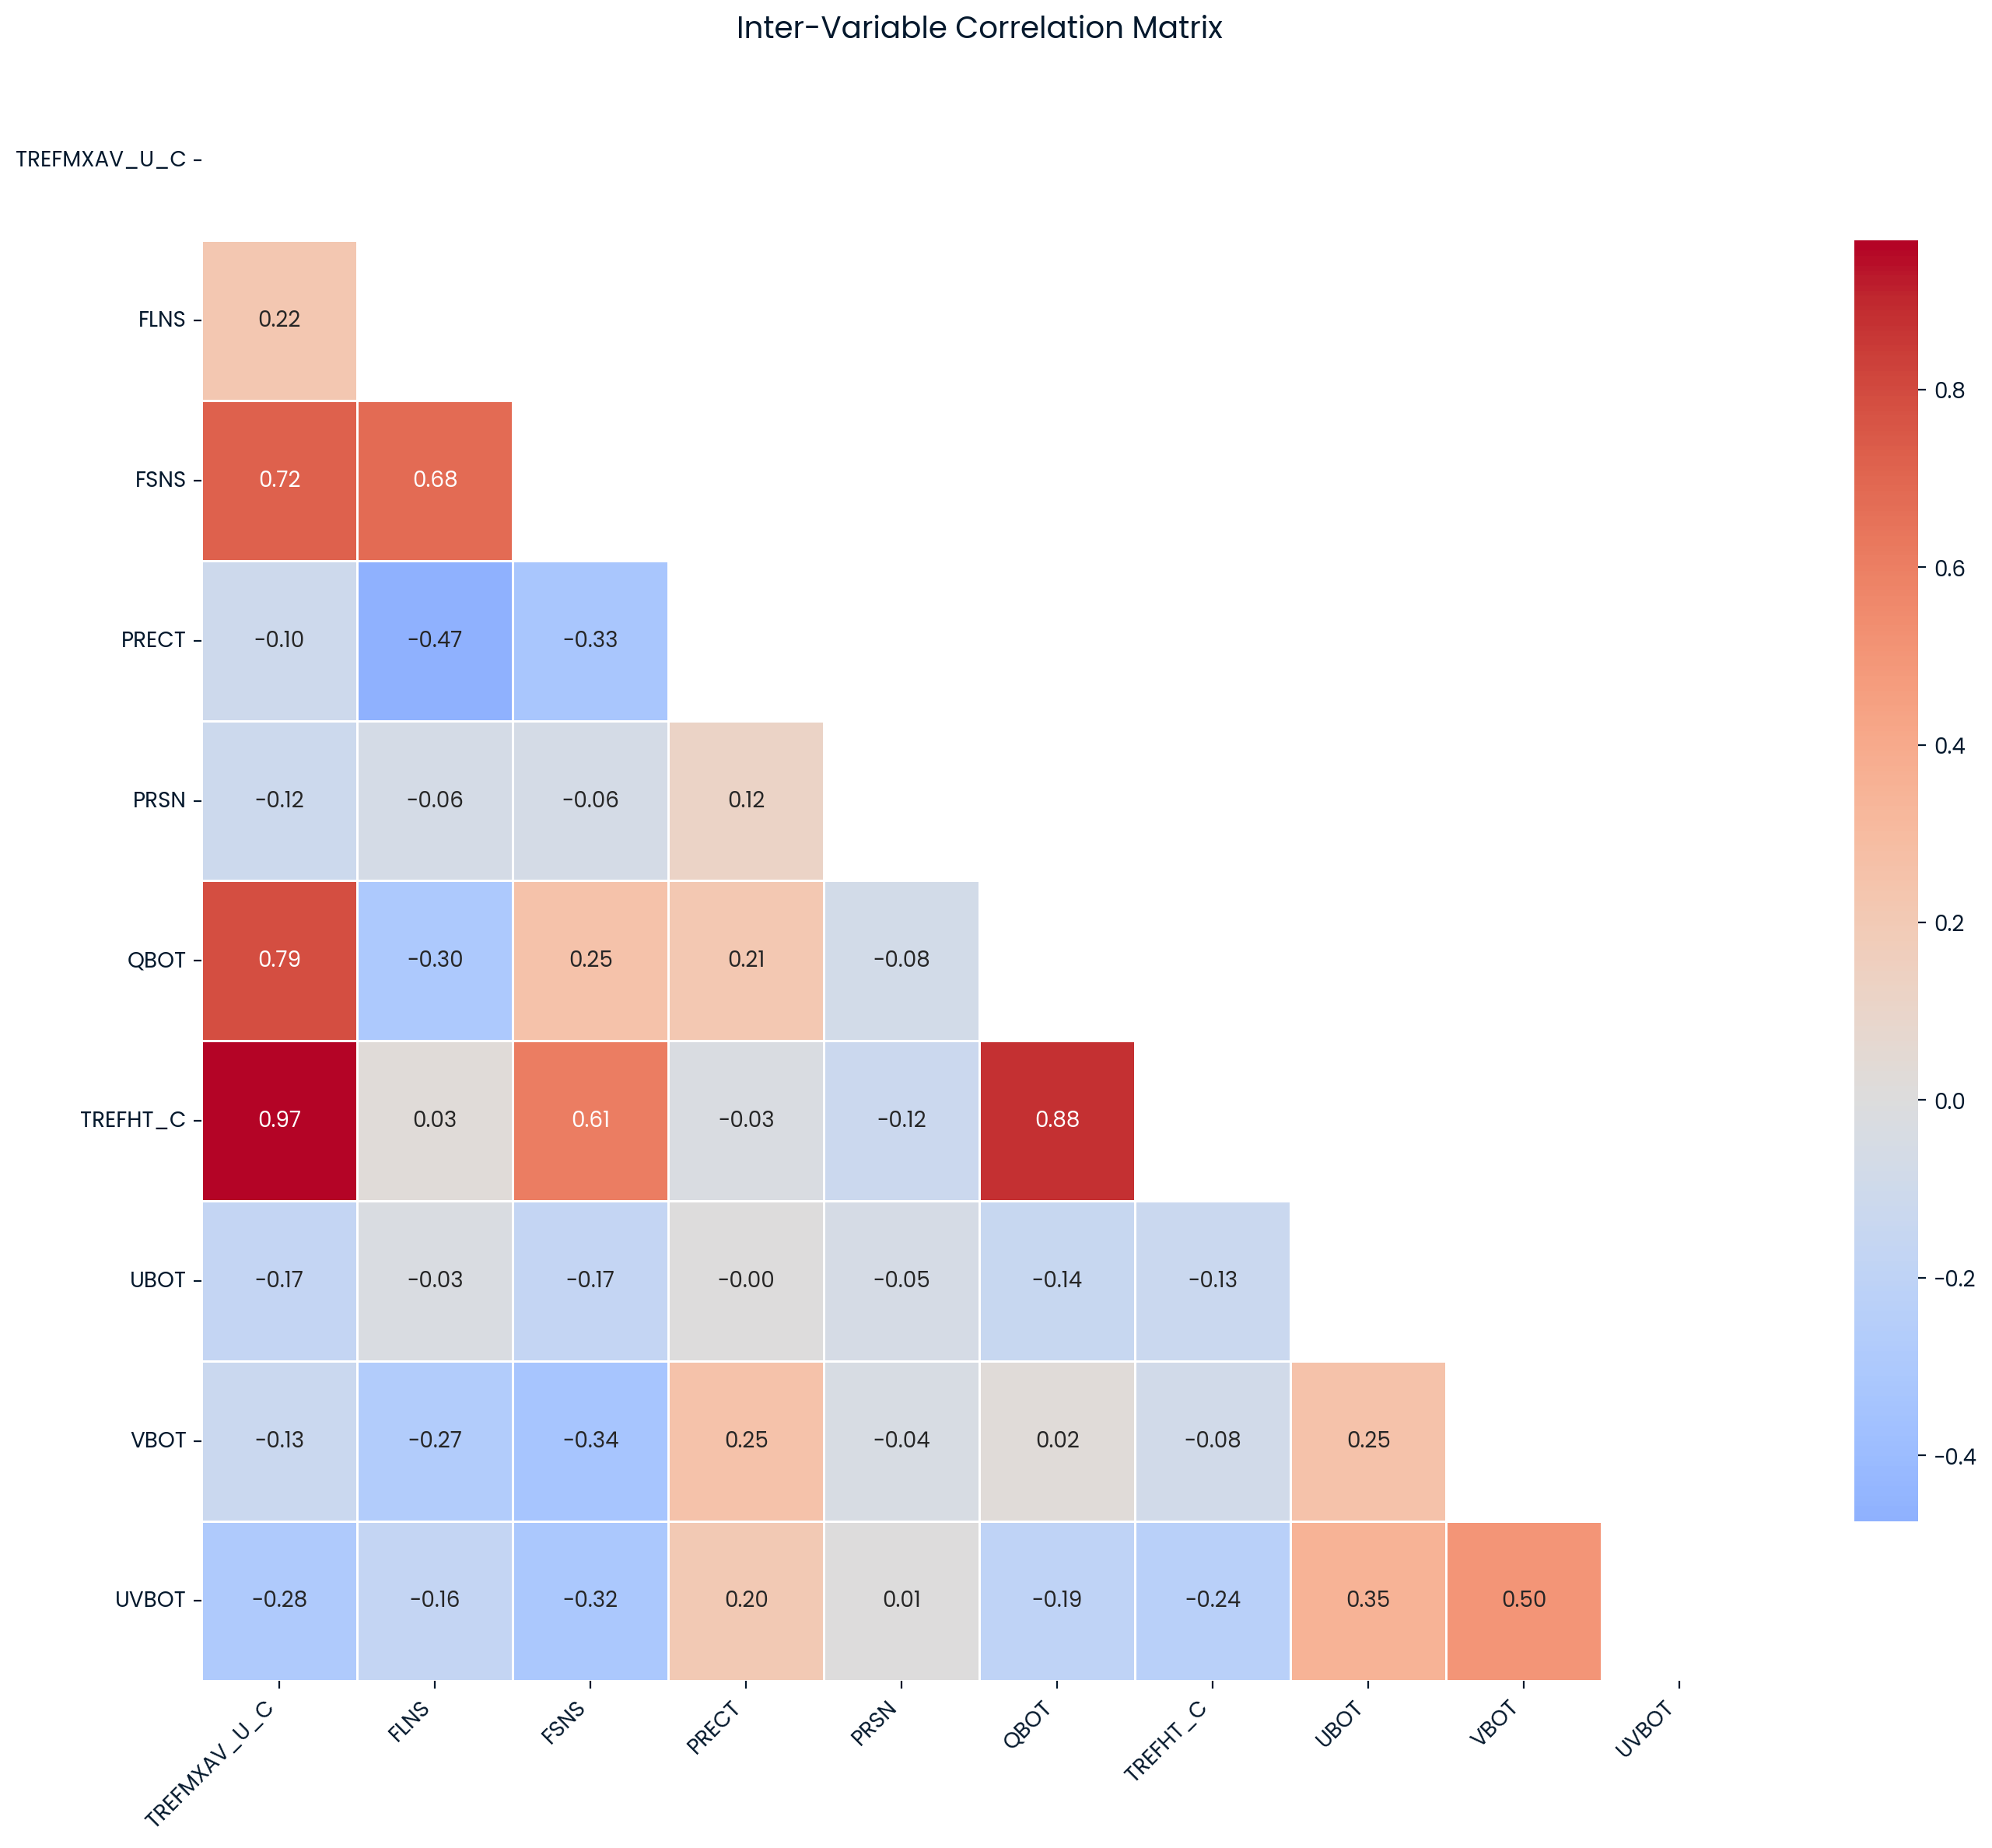

In [18]:
# Correlation Analysis
numeric_cols = ['TREFMXAV_U_C', 'FLNS', 'FSNS', 'PRECT', 'PRSN', 'QBOT',
               'TREFHT_C', 'UBOT', 'VBOT', 'UVBOT']
events = ['heatwave', 'cold_days', 'heavy_precipitation', 'strong_winds']

# plot 1: Variables vs Events Correlation
plt.figure(figsize=(12, 10))
corr_events = df[numeric_cols + events].corr()
sns.heatmap(
    corr_events.loc[numeric_cols, events], 
    annot=True, 
    cmap='coolwarm',
    vmin=-1, 
    vmax=1,
    fmt=".2f",
    linewidths=0.5
)
plt.title('Correlation Between Meteorological Variables and Extreme Events', pad=15)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('event_correlation.png', dpi=300, bbox_inches='tight') 
plt.show()


# plot 2: Inter-Variable Correlation Matrix
plt.figure(figsize=(14, 12))
corr_matrix = df[numeric_cols].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Upper triangle mask

heatmap = sns.heatmap(
    corr_matrix, 
    mask=mask,
    annot=True,
    cmap='coolwarm', 
    center=0,
    fmt=".2f", 
    linewidths=0.5,
    cbar_kws={'shrink': 0.8}
)

heatmap.set_xticklabels(
    heatmap.get_xticklabels(),
    rotation=45,
    ha='right',
    fontsize=10
)
heatmap.set_yticklabels(
    heatmap.get_yticklabels(),
    rotation=0,
    fontsize=10
)

plt.title('Inter-Variable Correlation Matrix', fontsize=14, pad=20)
plt.tight_layout()
plt.savefig('variable_correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

1. **`compare_extreme_days(event_col)`**  
   Analyzes distribution differences and performs Z-tests between extreme event days and normal days for a specific event type. Generates:  
   - Comparative boxplots showing variable distributions  
   - Z-statistics and p-values for each meteorological variable  
   - Sample size metadata for both groups  
   Returns a DataFrame with statistical results for single-event analysis.

2. **Main Workflow**  
   Executes batch processing across all defined extreme events to:  
   - Aggregate Z-test results from individual event analyses  
   - Generate a unified horizontal bar chart comparing Z-statistics  
   - Visualize cross-event variable impact patterns  
   - Automatically save comparative results as `z_statistics_comparison.png`  
   Produces an integrated dataset (`all_z_results`) containing all statistical outcomes for downstream analysis.


--- HEATWAVE ANALYSIS ---


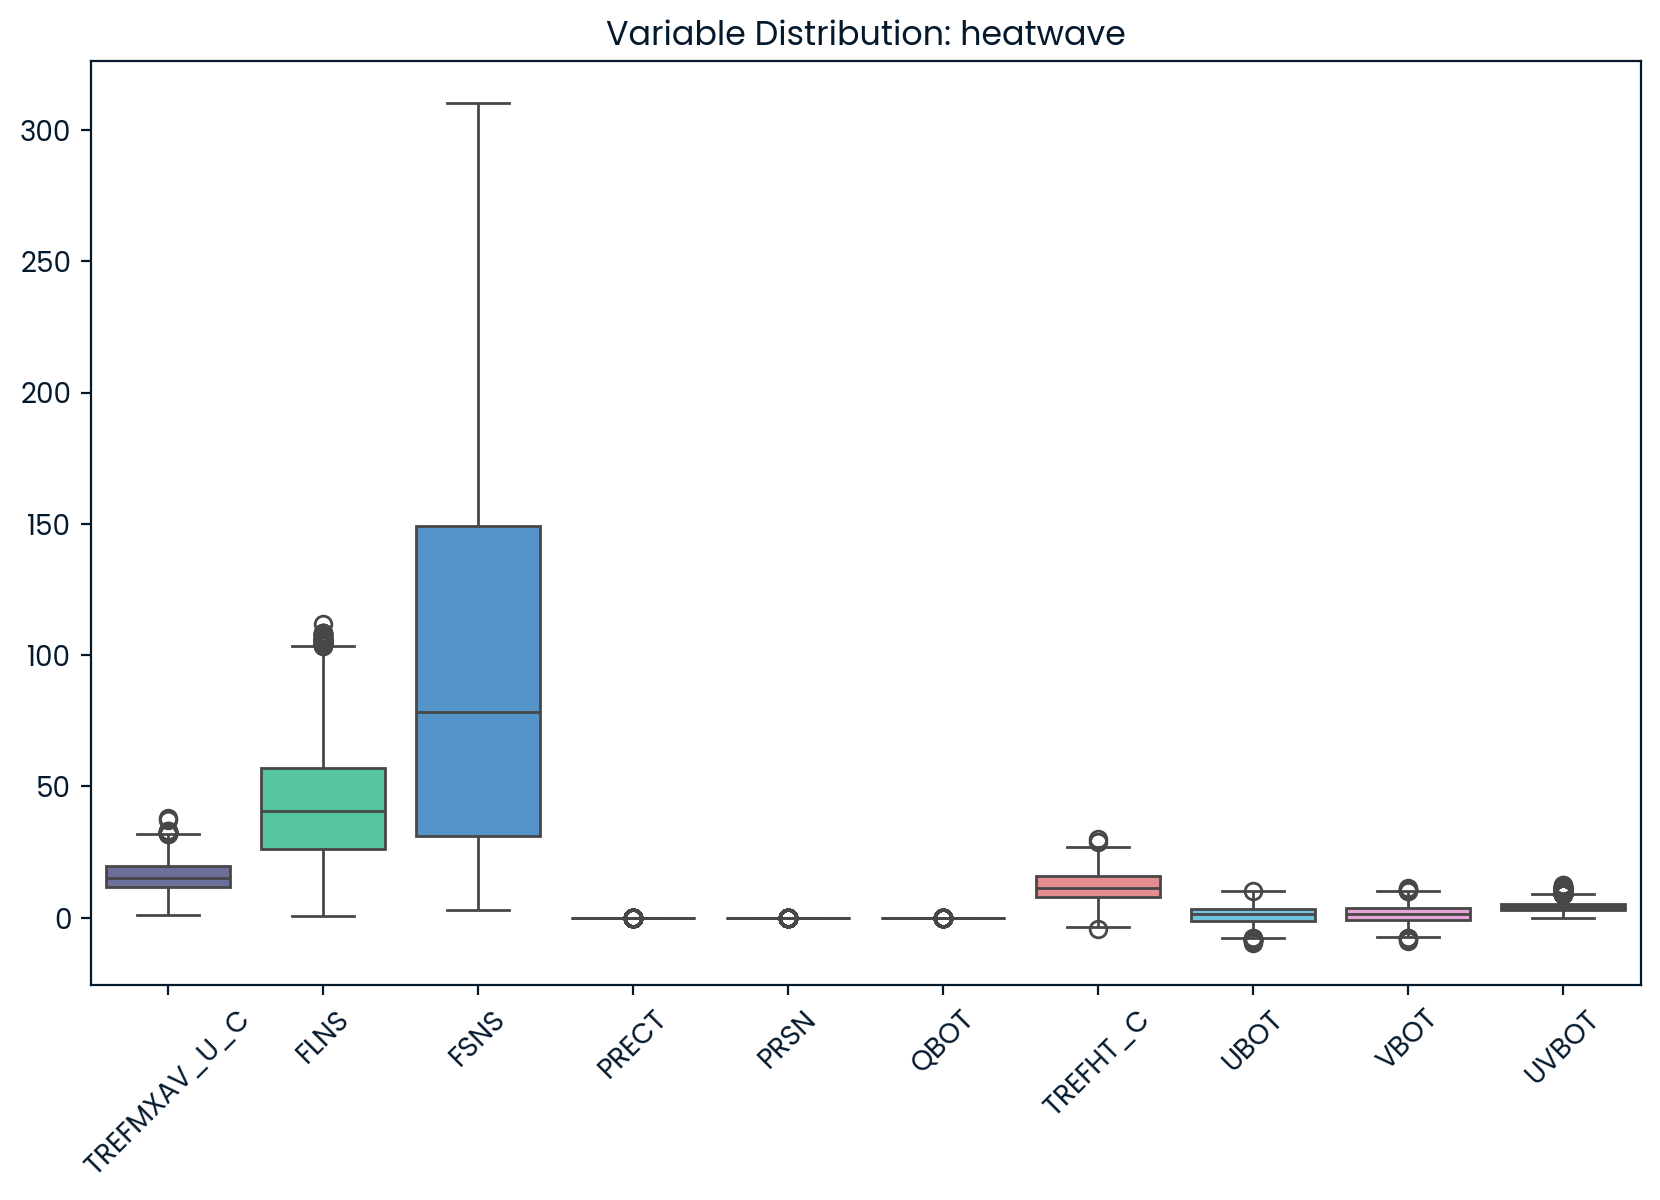

,Z Statistic,p-value,Extreme Sample Size,Normal Sample Size
TREFMXAV_U_C,226.033086,0.0,3621.0,23753.0
FLNS,39.260977,0.0,3621.0,23753.0
FSNS,106.086468,0.0,3621.0,23753.0
PRECT,-36.011973,0.0,3621.0,23753.0
PRSN,-10.725539,0.0,3621.0,23753.0
QBOT,99.412589,0.0,3621.0,23753.0
TREFHT_C,207.090856,0.0,3621.0,23753.0
UBOT,-30.662982,0.0,3621.0,23753.0
VBOT,-34.551638,0.0,3621.0,23753.0
UVBOT,-53.416772,0.0,3621.0,23753.0



--- COLD_DAYS ANALYSIS ---


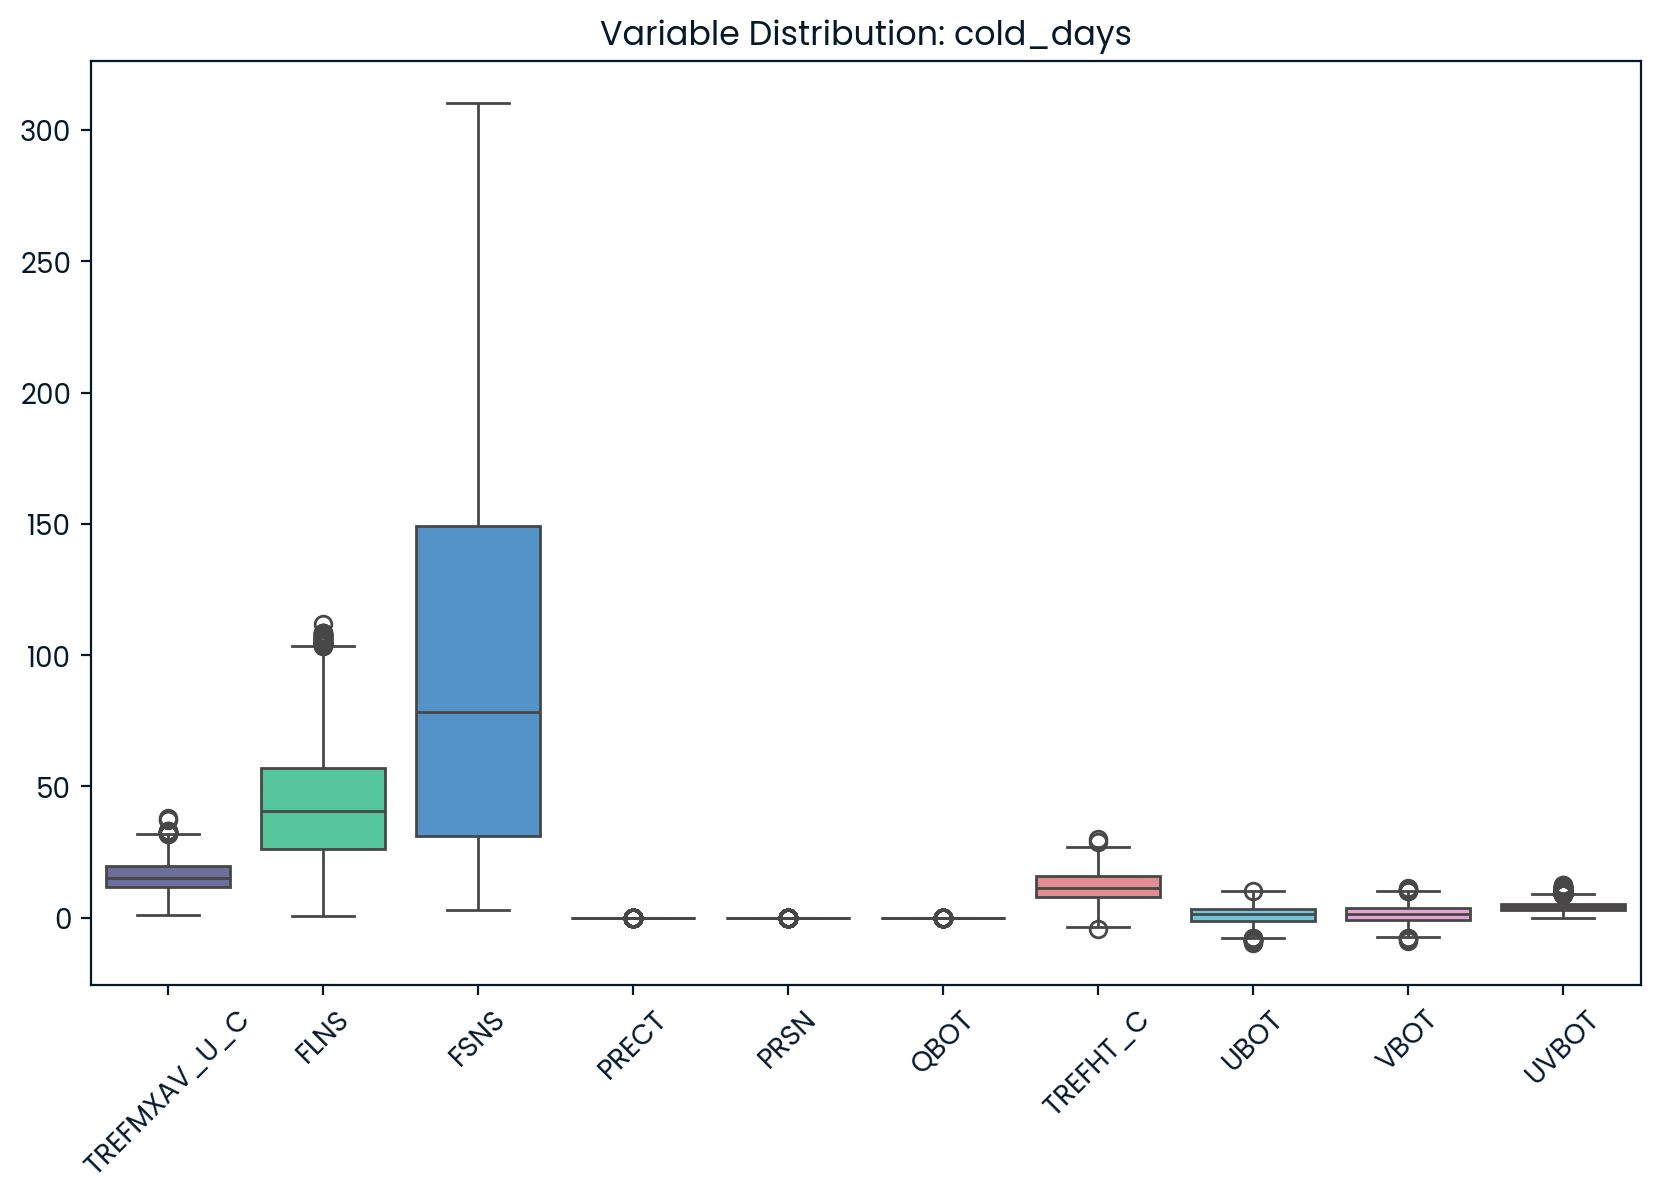

,Z Statistic,p-value,Extreme Sample Size,Normal Sample Size
TREFMXAV_U_C,-159.100535,0.0,991.0,26383.0
FLNS,22.148536,0.0,991.0,26383.0
FSNS,-46.420977,0.0,991.0,26383.0
PRECT,-13.813622,0.0,991.0,26383.0
PRSN,9.078813,0.0,991.0,26383.0
QBOT,-144.751325,0.0,991.0,26383.0
TREFHT_C,-210.131354,0.0,991.0,26383.0
UBOT,-10.354900,0.0,991.0,26383.0
VBOT,-26.122847,0.0,991.0,26383.0
UVBOT,-10.978248,0.0,991.0,26383.0



--- HEAVY_PRECIPITATION ANALYSIS ---


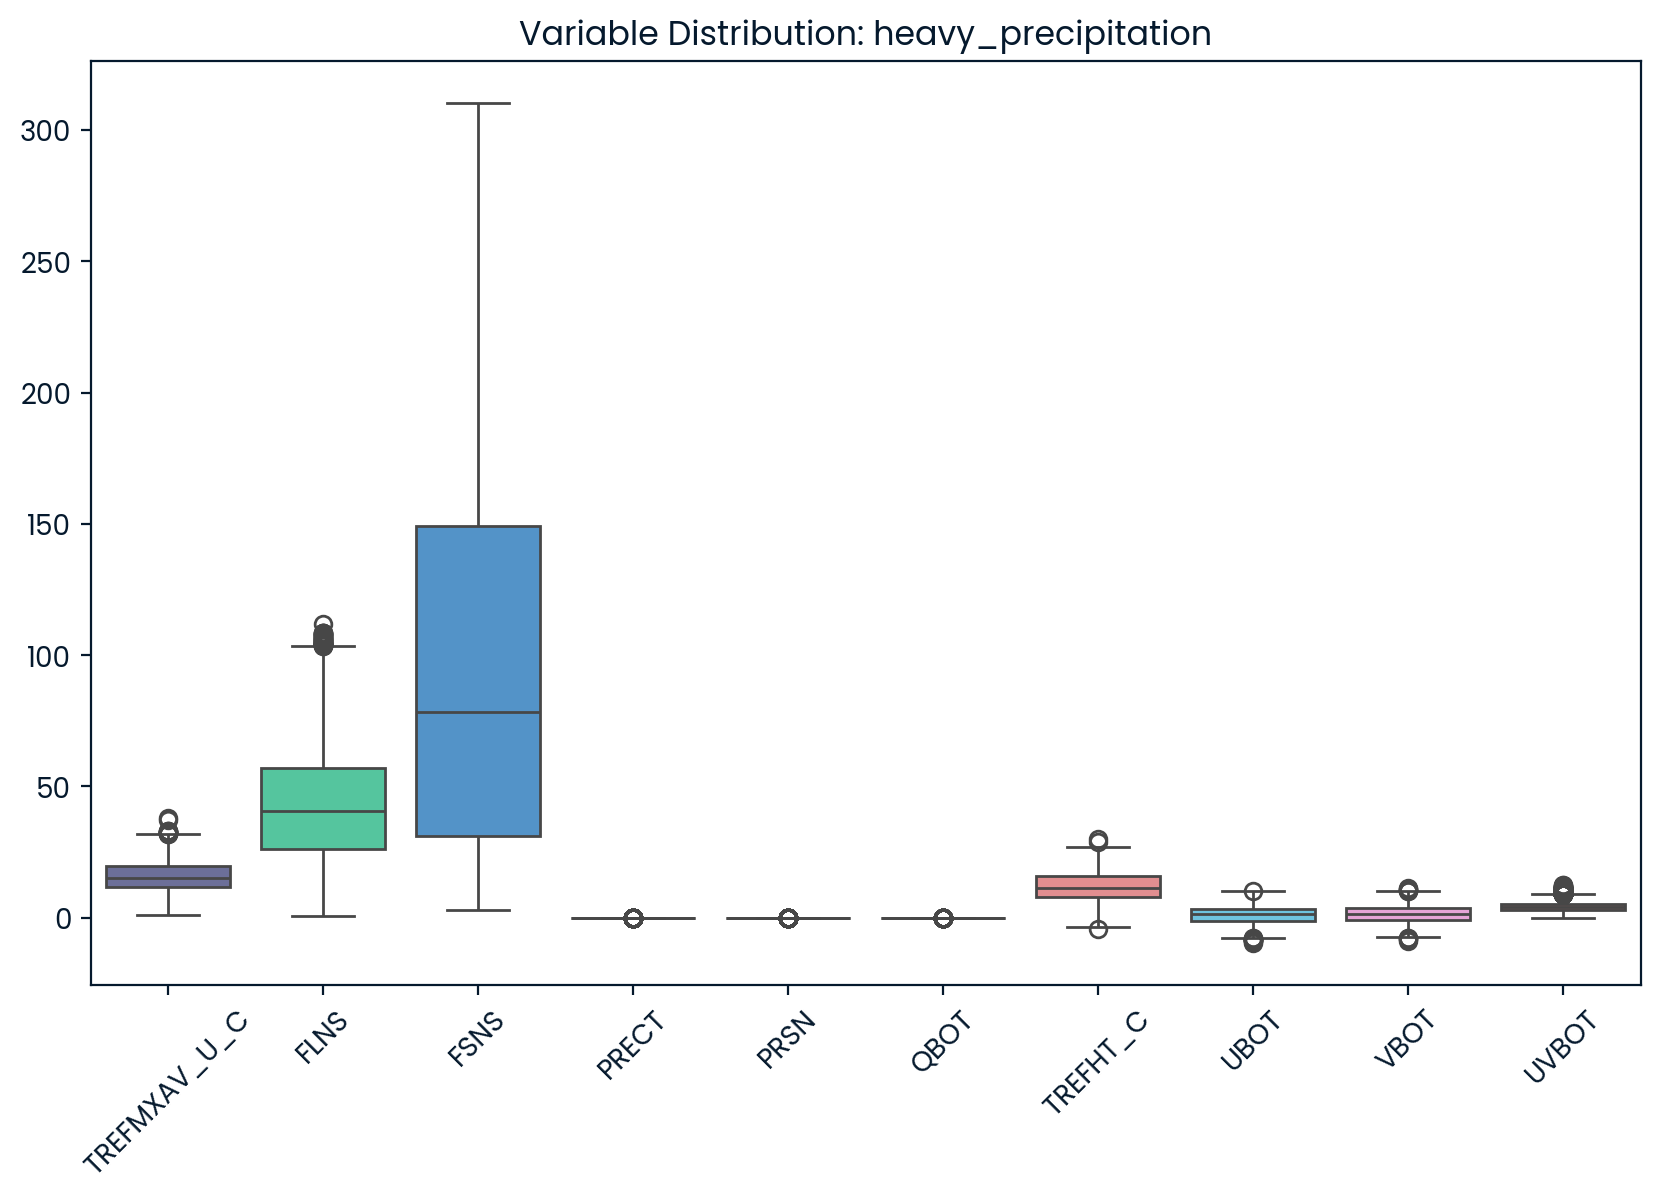

,Z Statistic,p-value,Extreme Sample Size,Normal Sample Size
TREFMXAV_U_C,-10.254530,0.000000e+00,1464.0,25910.0
FLNS,-83.898101,0.000000e+00,1464.0,25910.0
FSNS,-57.791024,0.000000e+00,1464.0,25910.0
PRECT,95.439914,0.000000e+00,1464.0,25910.0
PRSN,5.277451,1.309935e-07,1464.0,25910.0
QBOT,21.507411,0.000000e+00,1464.0,25910.0
TREFHT_C,-2.595633,9.441678e-03,1464.0,25910.0
UBOT,-10.518880,0.000000e+00,1464.0,25910.0
VBOT,12.059555,0.000000e+00,1464.0,25910.0
UVBOT,10.245504,0.000000e+00,1464.0,25910.0



--- STRONG_WINDS ANALYSIS ---


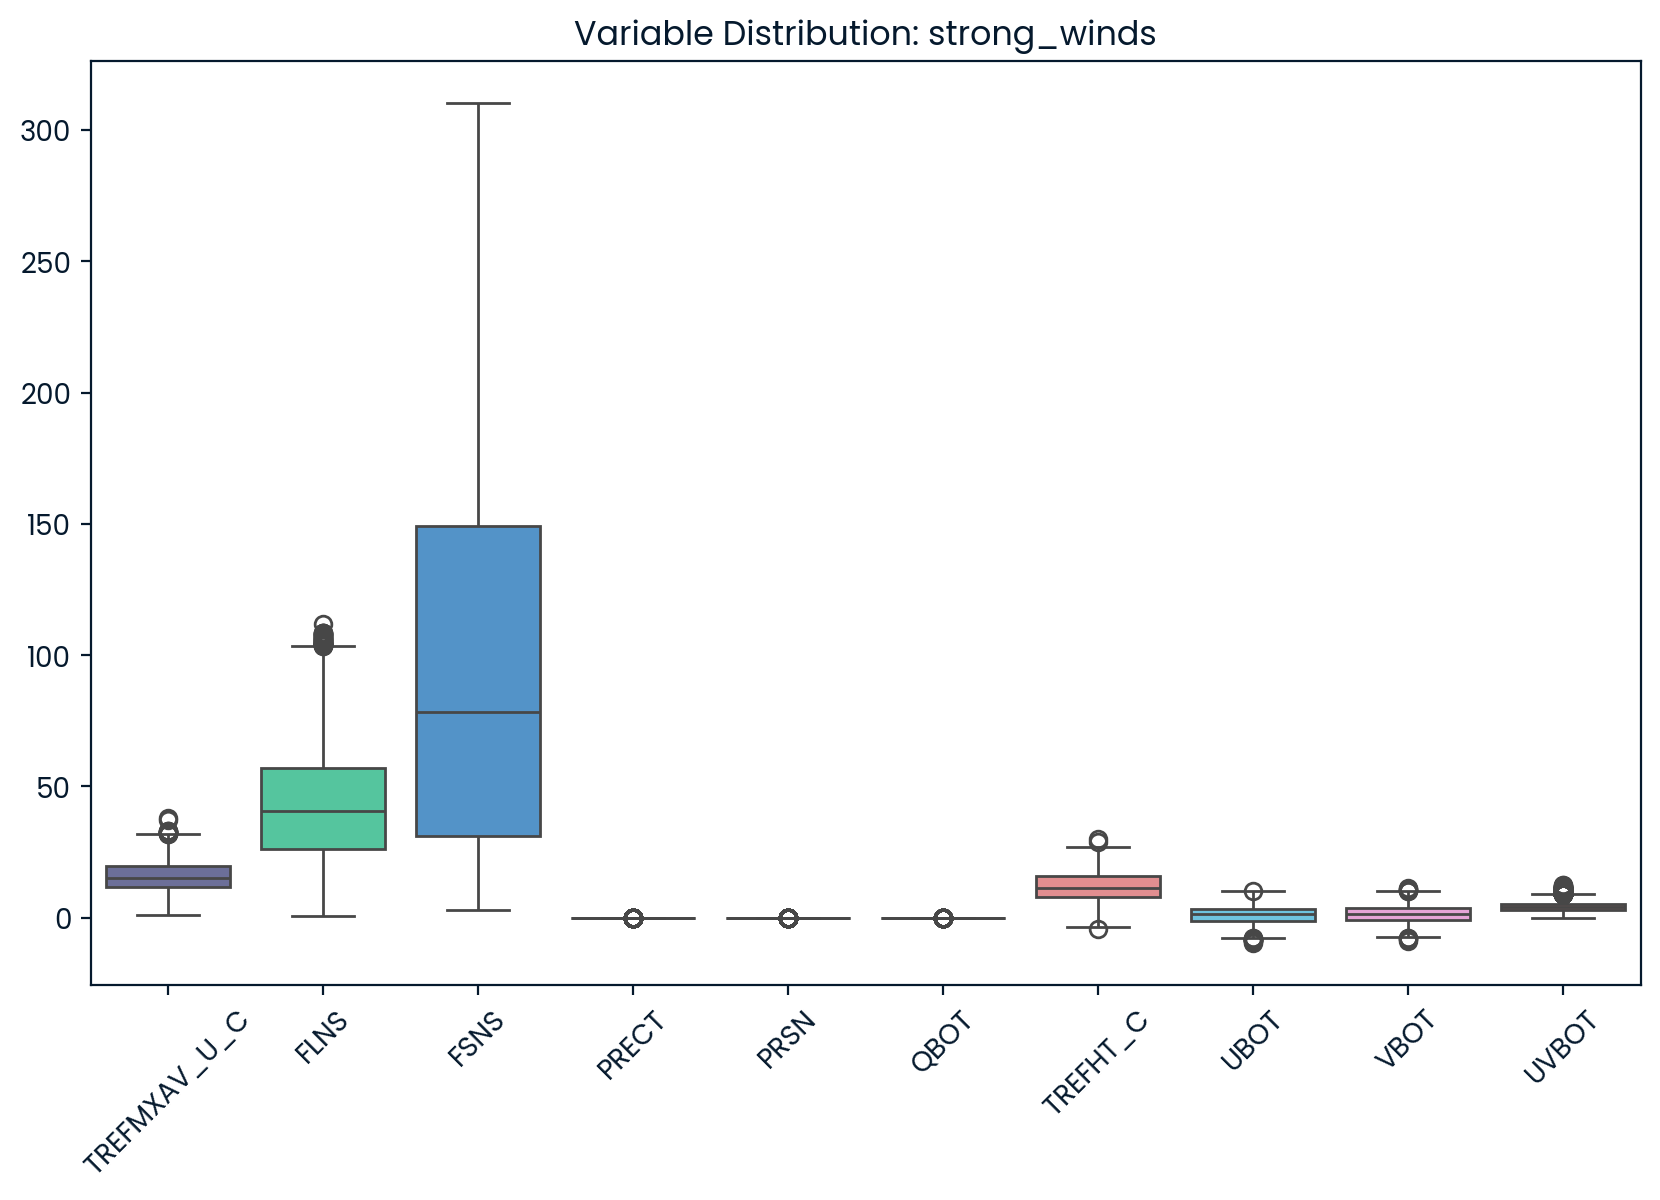

,Z Statistic,p-value,Extreme Sample Size,Normal Sample Size
TREFMXAV_U_C,-42.072948,0.000000,1469.0,25905.0
FLNS,-24.583744,0.000000,1469.0,25905.0
FSNS,-69.225519,0.000000,1469.0,25905.0
PRECT,19.971023,0.000000,1469.0,25905.0
PRSN,-1.284533,0.198955,1469.0,25905.0
QBOT,-24.756554,0.000000,1469.0,25905.0
TREFHT_C,-29.813197,0.000000,1469.0,25905.0
UBOT,38.158211,0.000000,1469.0,25905.0
VBOT,55.273518,0.000000,1469.0,25905.0
UVBOT,194.539810,0.000000,1469.0,25905.0


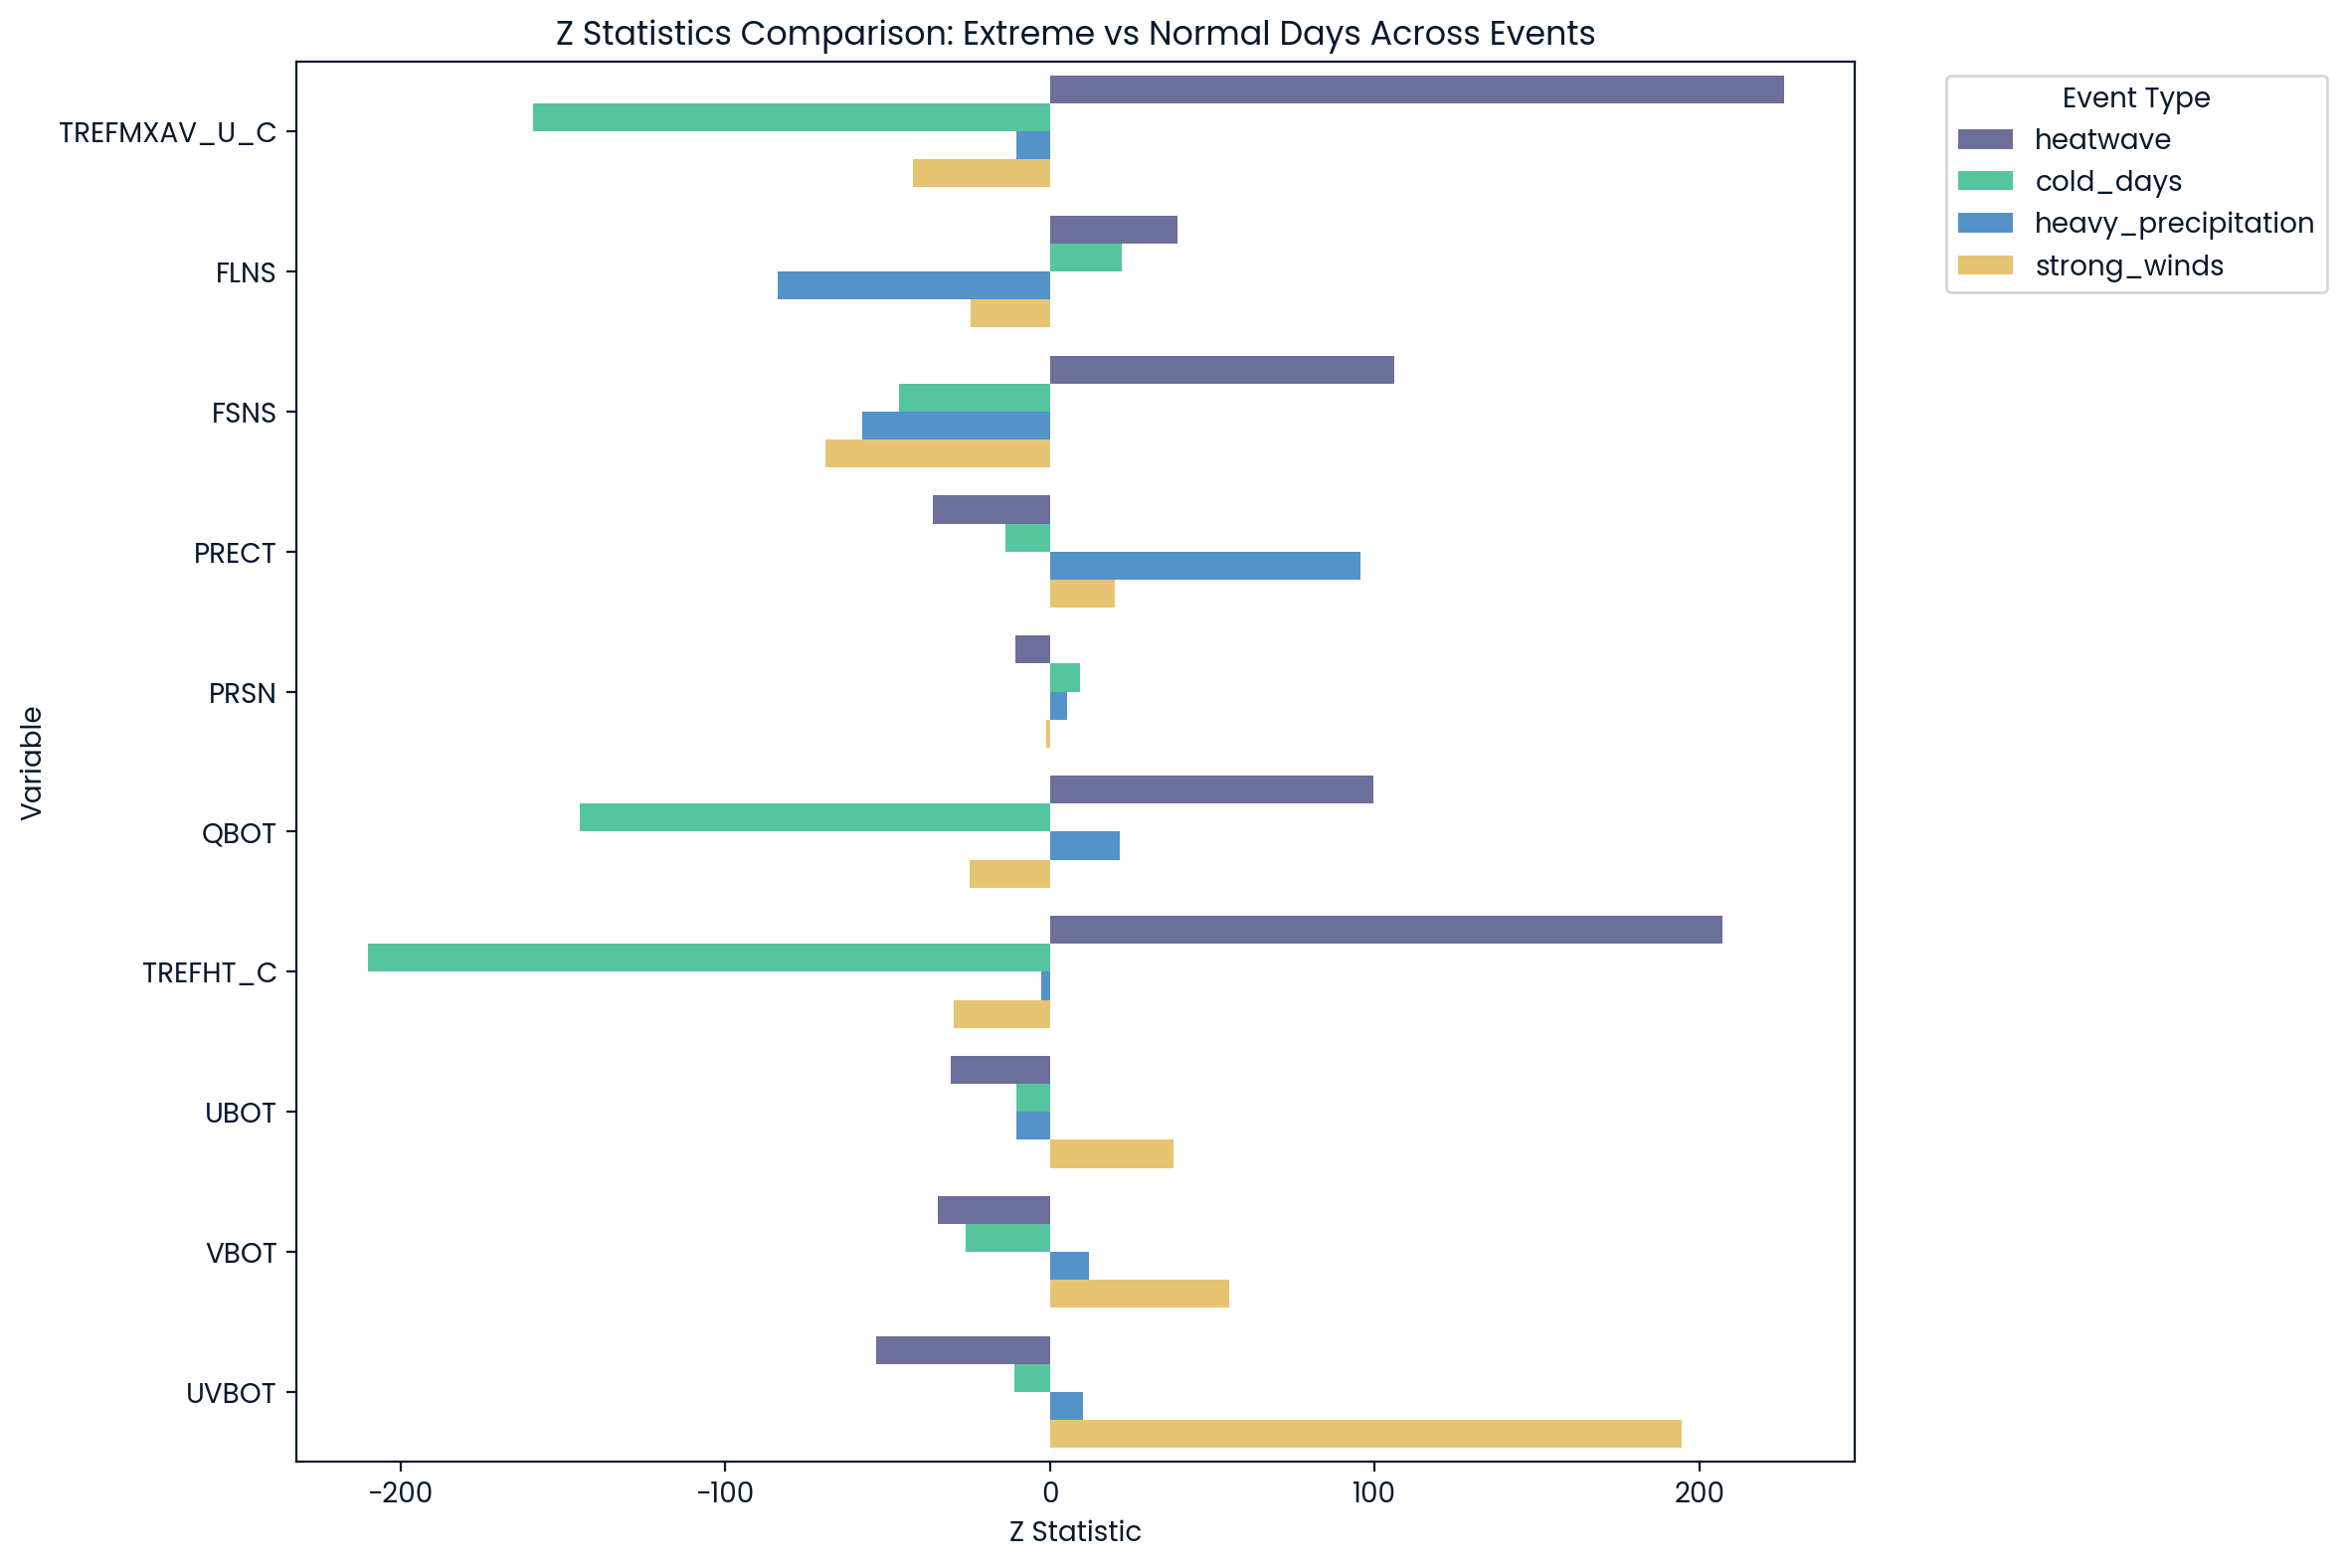

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

def compare_extreme_days(event_col):
    """Compare variable distributions between extreme and normal days, return Z-test results"""
    extreme = df[df[event_col]]
    normal = df[~df[event_col]]
    
    # Create comparative boxplot
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=pd.concat([extreme[numeric_cols], normal[numeric_cols]], 
               keys=['Extreme', 'Normal']))
    plt.xticks(rotation=45)
    plt.title(f'Variable Distribution: {event_col}')
    plt.show()
    
    # Perform Z-test for each numeric variable
    results = {}
    for col in numeric_cols:
        # Calculate statistics for both groups
        m1 = extreme[col].mean()
        s1 = extreme[col].std()
        n1 = len(extreme[col])
        
        m2 = normal[col].mean()
        s2 = normal[col].std()
        n2 = len(normal[col])
        
        # Standard error calculation
        se = np.sqrt(s1**2/n1 + s2**2/n2)
        
        # Handle division by zero
        if se == 0:
            Z = np.nan
            p_val = np.nan
        else:
            Z = (m1 - m2) / se
            p_val = 2 * (1 - norm.cdf(abs(Z)))
        
        results[col] = {
            'Z Statistic': Z, 
            'p-value': p_val,
            'Extreme Sample Size': n1, 
            'Normal Sample Size': n2
        }
    
    return pd.DataFrame(results).T

# Initialize DataFrame to store all Z results
all_z_results = pd.DataFrame()

# Process each event type
for event in events:
    print(f"\n--- {event.upper()} ANALYSIS ---")
    event_result = compare_extreme_days(event)
    display(event_result)  # Show detailed results for each event
    
    # Add event type and concatenate results
    event_result['Event'] = event
    all_z_results = pd.concat([all_z_results, event_result])

# Restructure data format for visualization
all_z_results = all_z_results.reset_index().rename(columns={'index': 'Variable'})

# Create comparative horizontal bar chart
plt.figure(figsize=(12, 8))
sns.barplot(
    data=all_z_results,
    y='Variable',
    x='Z Statistic',
    hue='Event',
    orient='h'
)
plt.title('Z Statistics Comparison: Extreme vs Normal Days Across Events')
plt.xlabel('Z Statistic')
plt.ylabel('Variable')
plt.legend(title='Event Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Save the final comparison plot
plt.savefig('z_statistics_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

1. **Lag Effect Analysis (`analyze_lag_effects`)**  
   Examines delayed relationships between meteorological variables and heatwave intensity by:  
   - **Hypothesis 1 (Humidity Precursor)**: Tests if humidity levels (`QBOT`) in preceding days correlate with subsequent heatwave intensity (`TREFMXAV_U`), generating `lag_analysis_1_humidity_heatwave.png`  
   - **Hypothesis 2 (Precipitation Trigger)**: Investigates how precipitation patterns (`PRECT`) and snowfall (`PRSN`) in prior days influence heatwave onset, visualized in `lag_analysis_2_precipitation_heatwave.png`  
   - **Hypothesis 3 (Radiation Dynamics)**: Analyzes delayed impacts of net longwave (`FLNS`) and solar radiation (`FSNS`) on heatwave development, output to `lag_analysis_3_radiation_heatwave.png`  

2. **Core Functionality**  
   - Creates time-lagged variables for specified meteorological parameters  
   - Calculates cross-correlation matrices between lagged variables and heatwave intensity  
   - Generates annotated heatmaps to visualize temporal relationships  
   - Automates high-resolution figure saving with standardized naming  

3. **Technical Implementation**  
   - Configurable lag window through `lag_days` parameter  
   - Modular hypothesis testing structure for extensibility  
   - Integrated visualization pipeline with consistent styling  
   - Memory management through plot closure after saving  

## 6. Conclusions ##

​1.The frequency and intensity of extreme events are expected to rise, potentially leading to more frequent and severe heat stress.​

​2.Heatwaves show dramatic rising trends, especially in later decades (2050–2080).​

​3.High humidity and radiation flux are strongly correlated with the occurrence of temperature extremes and can serve as early warning signals.​

## 7. References & Literature

-Klein Tank, A. and Können, G. (2003). Trends in Indices of Daily Temperature and Precipitation Extremes in Europe, 1946–99. Journal of Climate 16(22) pp. 3665-3680. ​

-Pedro José Roldán-Gómez, Paolo De Luca, Raffaele Bernardello, Markus G. Donat, Regional irreversibility of mean and extreme surface air temperature and precipitation in CMIP6 overshoot scenarios associated with interhemispheric temperature asymmetries, Earth System Dynamics, 10.5194/esd-16-1-2025, 16, 1, (1-27), (2025).​

-Seneviratne, S.I., X. Zhang, M. Adnan, W. Badi, C. Dereczynski, A. Di Luca, S. Ghosh, I. Iskandar, J. Kossin, S. Lewis, F. Otto, I. Pinto, M. Satoh, S.M. Vicente-Serrano, M. Wehner, and B. Zhou, 2021: Weather and Climate Extreme Events in a Changing Climate. In Climate Change 2021: The Physical Science Basis. Contribution of Working Group I to the Sixth Assessment Report of the Intergovernmental Panel on Climate Change[Masson-Delmotte, V., P. Zhai, A. Pirani, S.L. Connors, C. Péan, S. Berger, N. Caud, Y. Chen, L. Goldfarb, M.I. Gomis, M. Huang, K. Leitzell, E. Lonnoy, J.B.R. Matthews, T.K. Maycock, T. Waterfield, O. Yelekçi, R. Yu, and B. Zhou (eds.)]. Cambridge University Press, Cambridge, United Kingdom and New York, NY, USA, pp. 1513–1766, doi: 10.1017/9781009157896.013.​

-John E. Walsh, Thomas J. Ballinger, Eugénie S. Euskirchen, Edward Hanna, Johanna Mård, James E. Overland, Helge Tangen, Timo Vihma, Extreme weather and climate events in northern areas: A review, Earth-Science Reviews,Volume 209, 2020,103324,ISSN 00128252,https://doi.org/10.1016/j.earscirev.2020.103324.
